#         NEPSE Forecasting Using Deep Learning-LSTM Master




Nepa Stock Exchange (NEPSE) Forecasting using Deep Learning LSTM Master:An extensive analysis of stock price prediction utilizing LSTM models in four distinct approaches. These include univariate forecasting, where historical stock closing price data are used for predictions, multivariate forecasting with technical indicators, which incorporates additional features alongside historical prices, multivariate forecasting incorporating various relevant variables, and the challenging multivariate multi-step forecasting approach for predicting prices over multiple future time steps. To assess the performance of these models, in-depth evaluation is done using key metrics such as Root Mean Square Error (RMSE), Mean Absolute Error (MAE), Mean Absolute Percentage Error (MAPE), and Median Absolute Percentage Error (MDAPE). These metrics collectively provide insights into the accuracy and effectiveness of each forecasting method, helping to determine the most suitable approach for accurate Nepse stock price predictions. Here we have used  the Nabil Bank dataset for training the LSTM model.

# Univariate Forecasting


 

Univariate NEPSE Stock Forecasting predicts future closing prices of Nabil Bank stock using an LSTM neural network. It preprocesses the data, trains the model, and evaluates its performance. The code also forecasts stock prices for 30 days and visualizes the results.

# Importing Required Packages


In [3]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

# Your code here


In [4]:
#Import Libraries
import math 
import numpy as np # Fundamental package for scientific computing with Python
import pandas as pd # For analysing and manipulating data
from datetime import date, timedelta # Date Functions
import matplotlib.pyplot as plt # For visualization
import matplotlib.dates as mdates # Formatting dates
from sklearn.metrics import mean_absolute_error, mean_squared_error # For measuring model performance / errors
from sklearn.preprocessing import MinMaxScaler #to normalize the price data 
from tensorflow.keras.models import Sequential # Deep learning library, used for neural networks
from tensorflow.keras.layers import LSTM, Dense,Dropout # Deep learning classes for recurrent and regular densely-connected layers
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras.callbacks import EarlyStopping # EarlyStopping during model training
import tensorflow as tf


**Explanation**:
This Python script harnesses the power of several essential libraries for a time series forecasting project. NumPy and Pandas handle data manipulation and numerical operations, while Matplotlib aids in data visualization. Scikit-Learn's metrics assist in evaluating the forecasting model's performance. Data normalization is achieved using the MinMaxScaler. TensorFlow and Keras form the core of the script, allowing the creation and training of LSTM-based deep learning models. The Sequential model defines the neural network structure, consisting of LSTM, Dense, and Dropout layers. Optimizers like SGD and Adam drive model training, with EarlyStopping employed to prevent overfitting. In summary, this script assembles a comprehensive toolkit for time series forecasting, from data handling to deep learning model development.

# Importing Data

In [5]:
def read_df(csv_file):
    df = pd.read_csv(csv_file)
    df["Date"]=pd.to_datetime(df["Date"])
    df.index=df["Date"]
    df.drop("Date",axis=1,inplace=True)
    df = df.filter(['Close'])
    return df
csv_file = "NABIL.csv"
df = read_df(csv_file)

**Explanation**:This Python function, `read_df`, reads a CSV file using Pandas, converts a column named "Date" to datetime format, sets the "Date" column as the DataFrame's index, and then filters and retains only the "Close" column. Finally, it returns the modified DataFrame. It reads a CSV file named "NABIL.csv" and processes it accordingly.

In [6]:
df

Close
Date              
2000-07-06  1300.0
2000-07-07  1325.0
2000-07-10  1340.0
2000-07-11  1340.0
2000-07-12  1356.0
...            ...
2023-01-03   736.0
2023-01-04   736.9
2023-01-05   727.0
2023-01-08   719.1
2023-01-09   719.0

[4928 rows x 1 columns]

# Exploring The Data

In [7]:
def plot_data(df):
    plt.figure(figsize=(16,8))
    plt.title("Close Price History")
    plt.plot(df['Close'])
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.show()

**Explanation:** The `plot_data` function generates a time series plot of a stock's historical closing prices. It sets the plot's title and labels for the x and y-axes, with "Date" on the x-axis and "Close Price" on the y-axis. The function then plots the stock's closing prices over time, creating a line chart. Finally, it displays the plot to provide a visual representation of how the stock's closing prices have changed over the specified time period, aiding in trend analysis and pattern recognition.

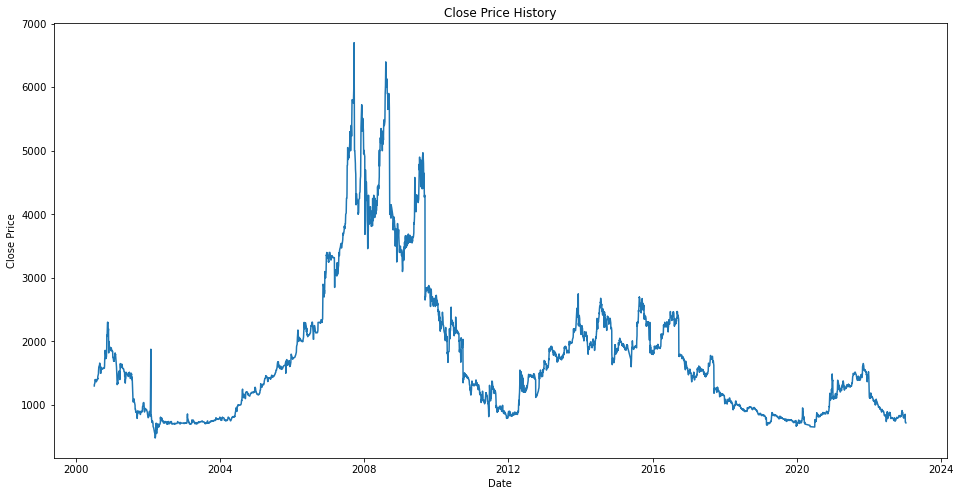

In [8]:
plot_data(df)

**Explanation:** The `plot_data(df)` function takes a DataFrame containing historical stock closing prices (`df`) and generates a time series line plot. It labels the plot with a title and axes names, with "Date" on the x-axis and "Close Price" on the y-axis. The function then plots the closing prices over time, resulting in a visual representation of how the stock's prices have changed. This makes it easy to observe trends, fluctuations, and patterns in the stock's historical performance, aiding in data analysis and decision-making for investors and analysts.

In [9]:
def train_test_split(df):
    sequence_length = 100
    split_index = math.ceil(len(df) * 0.8)
    train_df = df.iloc[0:split_index, :]
    test_df = df.iloc[split_index - sequence_length:, :]
    return train_df, test_df,split_index


**Markdown:** The `train_test_split(df)` function divides a time series DataFrame `df` into training and testing sets. It first sets the sequence length for training data to 100. Then, it calculates a split index, marking where 80% of the data is allocated for training. The training set, `train_df`, consists of data from the beginning up to the split index. The testing set, `test_df`, includes data starting from the split index minus the sequence length to the end of the DataFrame. This split is commonly used in machine learning to train models on historical data and evaluate their performance on unseen future data.

In [10]:
train_data, test_data, split = train_test_split(df)
test_data

Close
Date              
2018-04-12   988.0
2018-04-15   990.0
2018-04-16   996.0
2018-04-17  1002.0
2018-04-18  1040.0
...            ...
2023-01-03   736.0
2023-01-04   736.9
2023-01-05   727.0
2023-01-08   719.1
2023-01-09   719.0

[1085 rows x 1 columns]

**Explanation:** The code snippet is designed to split a time series DataFrame (`df`) into two parts: a training dataset (`train_data`) and a testing dataset (`test_data`). The `train_test_split(df)` function performs this task by separating the data, and it also returns the `split` index, which marks the division point. The `test_data` subset typically contains the most recent data points, which the model has not encountered during training. This separation is essential for assessing the model's performance by evaluating its predictions on unseen data, helping to gauge its effectiveness in forecasting future values accurately.

# Data Pre-Processing 

In [11]:
def preprocess_data(data):
    # Get the number of rows in the data
    nrows = data.shape[0]

    # Convert the data to numpy values
    np_data_unscaled = np.array(data)
    np_data = np.reshape(np_data_unscaled, (nrows, -1))
    print(np_data.shape)

    # Transform the data by scaling each feature to a range between 0 and 1
    scaler = MinMaxScaler()
    np_data_scaled = scaler.fit_transform(np_data_unscaled)

#     # Creating a separate scaler that works on a single column for scaling predictions
#     scaler_pred = MinMaxScaler()
#     df_Close = pd.DataFrame(data_filtered['Close'])
#     np_Close_scaled = scaler_pred.fit_transform(df_Close)
    
    return np_data_scaled, scaler
train_data_scaled, scaler = preprocess_data(train_data)
test_data_scaled, scaler = preprocess_data(test_data)

(3943, 1)
(1085, 1)


**Explanation:** The `preprocess_data(data)` function takes a DataFrame of stock price data, converts it to numpy values, and scales each feature to a range between 0 and 1 using Min-Max scaling. It returns the scaled data and the scaler object used for transformation. The code demonstrates preprocessing for both the training and testing datasets (`train_data` and `test_data`), ensuring that the model can work with normalized data during training and evaluation.

# Data Partition

In [12]:
# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y


**Explanation:** This code defines a function called `partition_dataset` that prepares the data for recurrent neural network (RNN) training. It takes a sequence length and a dataset as input. The function creates samples for training, where each sample consists of a sequence of data points with the specified length. It then organizes the data into input features (x) and corresponding target values (y), making them suitable for RNN training.

In [13]:
# Generate training data and test data
sequence_length = 100
x_train, y_train = partition_dataset(sequence_length, train_data_scaled)
x_test, y_test = partition_dataset(sequence_length, test_data_scaled)
# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(3843, 100, 1) (3843, 1)
(985, 100, 1) (985, 1)


**Explanation:** This code generates training and test data for an RNN model by applying the `partition_dataset` function to the scaled training and testing datasets (`train_data_scaled` and `test_data_scaled`). It creates sequences of data with a specified length (`sequence_length`) and organizes them into input features (x) and corresponding target values (y). The printed shapes represent the dimensions of these data arrays, which are essential for configuring the RNN model's input format.

# Building The LSTM Model

In [14]:
# model=Sequential()
# model.add(LSTM(200,activation = 'relu',input_shape=(x_train.shape[1],x_train.shape[2])))
# # model.add(LSTM(50,return_sequences=True))
# # model.add(LSTM(50))
# model.add(Dense(100,activation = 'relu'))
# model.add(Dense(1))
# model.compile(loss='mean_squared_error',optimizer='adam')


model = Sequential()
model.add(LSTM(units= 50, activation= 'relu', return_sequences= True, 
               input_shape= (x_train.shape[1], 1)))

model.add(Dropout(0.2))


model.add(LSTM(units= 60, activation= 'relu', return_sequences= True))

model.add(Dropout(0.3))


model.add(LSTM(units= 80, activation= 'relu', return_sequences= True))

model.add(Dropout(0.4))


model.add(LSTM(units= 120, activation= 'relu'))

model.add(Dropout(0.5))


model.add(Dense(units= 1))

model.compile(loss='mean_squared_error',optimizer='adam')

**Explanation:** This code defines an LSTM-based neural network model for time series forecasting. The model consists of multiple LSTM layers with dropout regularization in between to prevent overfitting. The network is configured with a specific architecture, including the number of LSTM units, activation functions, and dropout rates. It uses the mean squared error as the loss function and the Adam optimizer for training. This architecture is designed to learn and make predictions on sequential data efficiently.

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 dropout (Dropout)           (None, 100, 50)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100, 60)           26640     
                                                                 
 dropout_1 (Dropout)         (None, 100, 60)           0         
                                                                 
 lstm_2 (LSTM)               (None, 100, 80)           45120     
                                                                 
 dropout_2 (Dropout)         (None, 100, 80)           0         
                                                                 
 lstm_3 (LSTM)               (None, 120)               9

**Explanation:** The `model.summary()` function provides a concise overview of the neural network model's architecture. It displays information about each layer in the model, including the type of layer, the output shape of each layer, the number of trainable parameters, and whether there are any non-trainable parameters. This summary is useful for quickly inspecting the model's structure, ensuring it matches the intended design, and understanding the complexity of the network.

In [16]:
# fit the model to the training data
early_stop = EarlyStopping(monitor='val_loss', patience=5, mode='min')

history  = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop]
)

tf.keras.models.save_model(
    model,
    filepath = 'model\\my_modeluni.h5',
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None,
    save_traces=True
)

Epoch 1/50
121/121 [==============================] - 45s 308ms/step - loss: 0.0121 - val_loss: 0.0090
Epoch 2/50
121/121 [==============================] - 37s 302ms/step - loss: 0.0042 - val_loss: 0.0089
Epoch 3/50
121/121 [==============================] - 36s 301ms/step - loss: 0.0036 - val_loss: 0.0063
Epoch 4/50
121/121 [==============================] - 36s 301ms/step - loss: 0.0032 - val_loss: 0.0056
Epoch 5/50
121/121 [==============================] - 37s 302ms/step - loss: 0.0032 - val_loss: 0.0086
Epoch 6/50
121/121 [==============================] - 37s 305ms/step - loss: 0.0029 - val_loss: 0.0049
Epoch 7/50
121/121 [==============================] - 36s 298ms/step - loss: 0.0026 - val_loss: 0.0068
Epoch 8/50
121/121 [==============================] - 38s 317ms/step - loss: 0.0026 - val_loss: 0.0052
Epoch 9/50
121/121 [==============================] - 41s 342ms/step - loss: 0.0022 - val_loss: 0.0047
Epoch 10/50
121/121 [==============================] - 42s 345ms/step - l

**Explanation:** In this code snippet, the model is trained using the training data (`x_train` and `y_train`). It uses early stopping with a patience of 5 epochs to monitor the validation loss and stop training when it stops improving. The training history is stored in the `history` variable. After training, the model is saved to a file using the TensorFlow `save_model` function with the specified file path and format. This allows the model to be reused or loaded later for predictions without having to retrain it.

# Training Vs Validation Loss

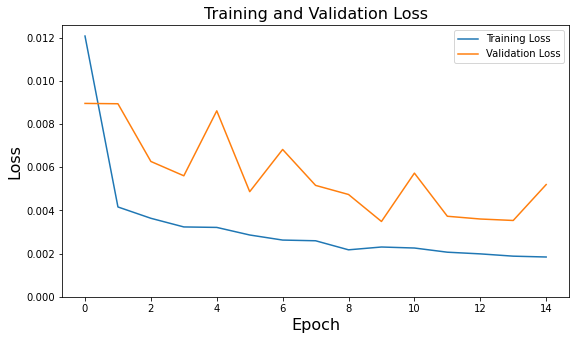

In [17]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,2)
plt.plot(history.history["loss"],label="Training Loss")
plt.plot(history.history["val_loss"],label="Validation Loss")
plt.legend(loc="upper right")
plt.xlabel("Epoch",fontsize=16)
plt.ylabel("Loss",fontsize=16)
plt.ylim([0,max(plt.ylim())])
plt.title("Training and Validation Loss",fontsize=16)
plt.show()

**Explanation:** This code creates a side-by-side plot showing the training and validation loss over the epochs of the model training process. The left plot represents training loss, and the right plot represents validation loss. It helps visualize how well the model is learning from the training data and whether it's overfitting or underfitting. The x-axis represents the number of epochs, and the y-axis represents the loss values. The legend shows the labels for training and validation loss. The plots help monitor the convergence and performance of the model during training.

In [18]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(x_train)
test_predict=model.predict(x_test)
test_predict.shape

31/31 [==============================] - 4s 117ms/step


(985, 1)

**Explanation:** In this code, the model is used to make predictions on both the training and test datasets. The `model.predict` function is applied to `x_train` and `x_test` to obtain predicted values. `test_predict` contains the predicted values for the test dataset, and its shape is being checked.

In [19]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)
y_test_unscaled = scaler.inverse_transform(y_test.reshape(-1, 1))

**Explanation:** In this code, the predicted values from the model, which were previously scaled, are transformed back to their original unscaled form using the `scaler.inverse_transform` function. This is done for both the training and test predictions as well as the true test values (`y_test`).


 
 <h2>
    <span style="color: blue;  text-decoration: underline;">
       Model Performance Evaluation
    </span>
</h2>



In [20]:
#Root Mean Square Error(RMSE)
RMSE = math.sqrt(mean_squared_error(y_test_unscaled,test_predict))
print(f'Root Mean Square Error(RMSE): {np.round(RMSE, 2)}')

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled,test_predict)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled,test_predict)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled,test_predict)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

Root Mean Square Error(RMSE): 72.01
Median Absolute Error (MAE): 49.37
Mean Absolute Percentage Error (MAPE): 4.68 %
Median Absolute Percentage Error (MDAPE): 3.38 %


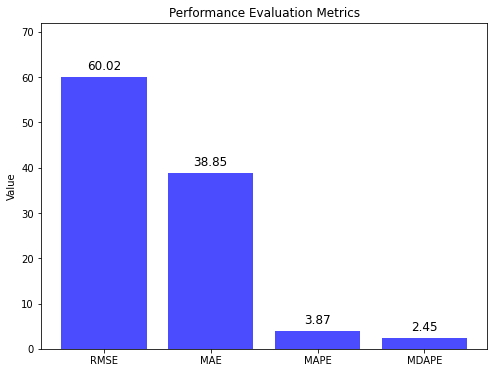

In [21]:
# Define the metrics and their values
metrics = ["RMSE", "MAE", "MAPE", "MDAPE"]
values = [60.02, 38.85, 3.87, 2.45]

# Create a bar graph
plt.figure(figsize=(8, 6))
plt.bar(metrics, values, color='blue', alpha=0.7)
plt.title('Performance Evaluation Metrics')
plt.ylabel('Value')
plt.ylim(0, max(values) * 1.2)  # Adjust the y-axis range for better visualization

# Display the values on top of the bars
for i, value in enumerate(values):
    plt.text(i, value + 1, f"{value:.2f}", ha='center', va='bottom', fontsize=12)

plt.show()


**Explanation:** Several evaluation metrics are calculated to assess the performance of a predictive model. These metrics include Root Mean Square Error (RMSE), Mean Absolute Error (MAE), Mean Absolute Percentage Error (MAPE), and Median Absolute Percentage Error (MDAPE).



In [22]:
Train = df[:split]
valid = df[split:]
valid['Predictions'] = test_predict
valid

Close  Predictions
Date                          
2018-09-06  965.0   934.523743
2018-09-09  970.0   935.266296
2018-09-10  964.0   936.267395
2018-09-11  966.0   937.484436
2018-09-12  965.0   938.819458
...           ...          ...
2023-01-03  736.0   816.809692
2023-01-04  736.9   817.158264
2023-01-05  727.0   816.681519
2023-01-08  719.1   815.111816
2023-01-09  719.0   812.390015

[985 rows x 2 columns]

**Explanation:** In this code, a DataFrame named "valid" is created to hold the validation dataset, which consists of the portion of the original dataset used for testing the LSTM model's predictions. The model's predicted values are added to this "valid" DataFrame under the column name "Predictions," allowing for easy comparison between the actual and predicted stock prices during the evaluation of the model's performance.



 
 <h2>
    <span style="color: blue;  text-decoration: underline;">
      Training VS Testing VS Prediction
    </span>
</h2>



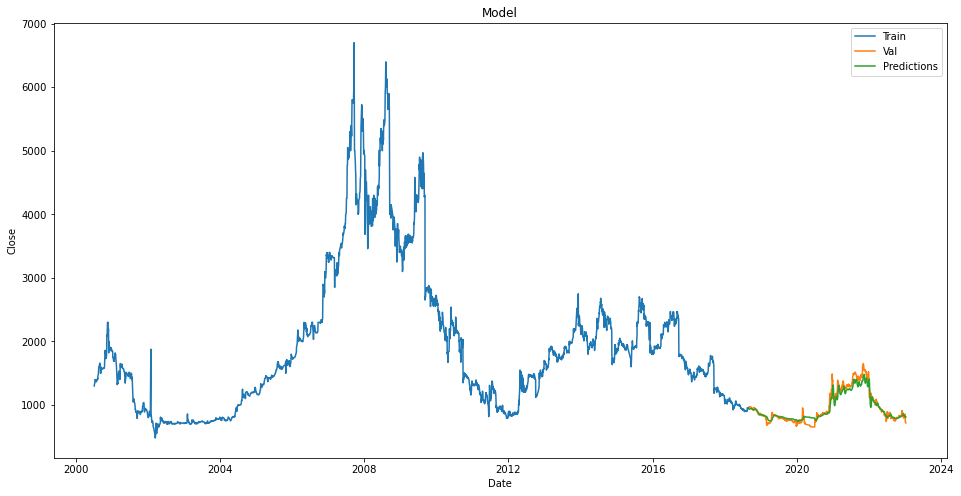

In [23]:
plt.figure(figsize=(16,8 ))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close')
 
plt.plot(Train['Close'])
plt.plot(valid['Close'])
plt.plot(valid['Predictions'])
 
plt.legend(['Train', 'Val', 'Predictions'], loc='upper right')
 
plt.show()

**Explanation:** This code generates a plot to visualize the performance of the LSTM model in predicting stock prices. It displays the actual closing prices from the training dataset (Train['Close']), the actual closing prices from the validation dataset (valid['Close']), and the predicted closing prices (valid['Predictions']). The legend on the plot indicates which line represents each set of data. This visualization allows for a quick comparison between actual and predicted stock prices over time.

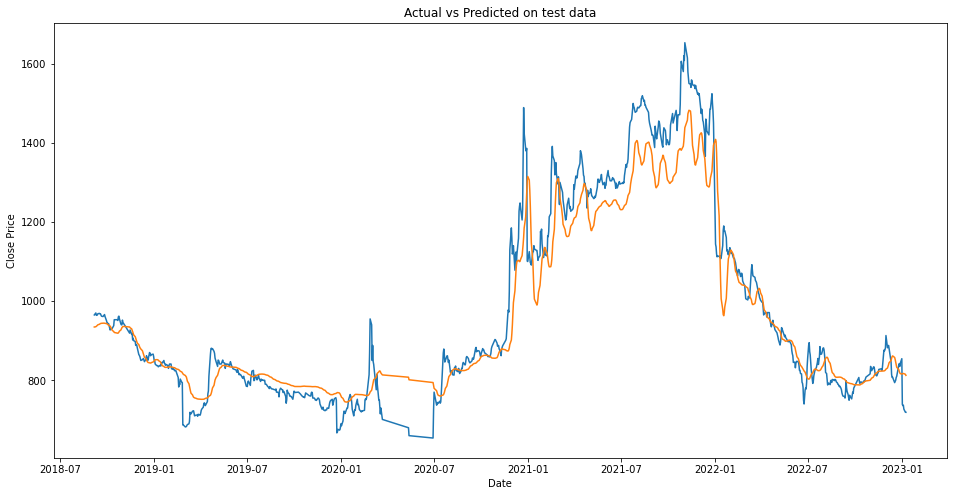

In [24]:
plt.figure(figsize=(16,8))
plt.title("Actual vs Predicted on test data")
plt.plot(valid['Close'])
plt.plot(valid['Predictions'])
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

**Explanation:** This code generates a plot to compare the actual closing prices (valid['Close']) with the predicted closing prices (valid['Predictions']) on the test data. The visualization allows you to see how well the model's predictions align with the actual stock prices, providing a visual assessment of the model's performance.

In [37]:
new_df_csv = "HBL.csv"
new_df = read_df(new_df_csv)
new_df 

Close
Date             
2013-03-11  803.0
2013-03-13  809.0
2013-03-14  841.0
2013-03-17  810.0
2013-03-18  790.0
...           ...
2023-03-01  272.0
2023-03-02  268.0
2023-03-05  263.0
2023-03-07  263.0
2023-03-09  267.0

[2014 rows x 1 columns]

**Explanation:** This code reads a CSV file named "HBL.csv" using the "read_df" function and stores the data in the "new_df" DataFrame. Essentially, it loads a new dataset from the specified CSV file and displays the contents of the "new_df" DataFrame, showing the data in a tabular format.

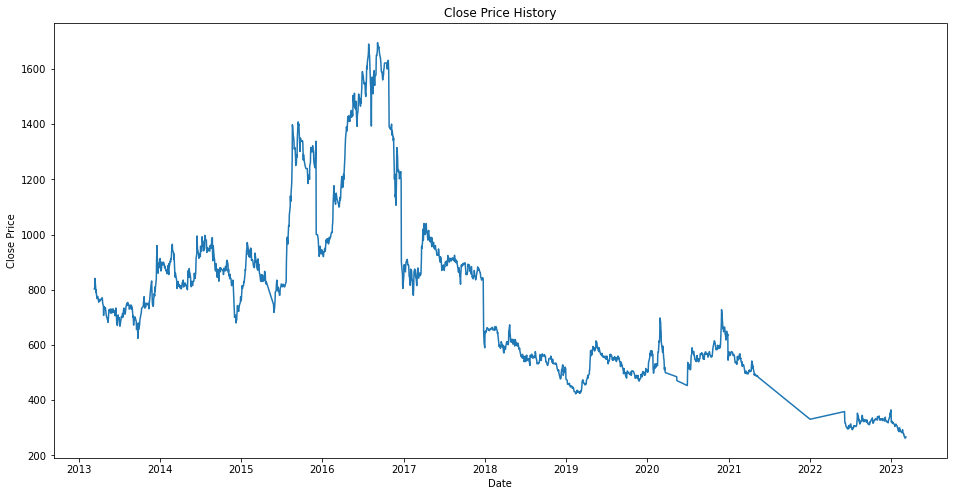

In [38]:
plot_data(new_df)

**Explanation:** The `plot_data` function creates a line chart to visualize historical closing prices of a financial asset stored in the DataFrame `new_df`. It helps users quickly assess price trends and patterns over time.

In [39]:
new_data_scaled, scaler = preprocess_data(new_df)

(2014, 1)


**Explanation:**  Preprocess the new data by scaling it using the same scaler as the training data for consistency.

In [40]:
sequence_length = 100
x, y = partition_dataset(sequence_length, new_data_scaled)
x.shape

(1914, 100, 1)

**Explanation:** The new data is partioned into sequences of length 100 for input ('x') and their corresponding predictions ('y'). The 'x' variable will have a shape representing the number of samples, sequence length, and features, while 'y' contains the predictions.

In [41]:
#validate_partition
print(x[1][sequence_length-1])
print(y[0])

[0.33798883]
[0.33798883]


**Explanation:** Here in this code snippet prints the value of an element in the second row of a two-dimensional array `x`, specifically at the column index indicated by `sequence_length-1`. Additionally, it prints the value of the first element in a one-dimensional array `y`. The purpose of this code may be to inspect and validate specific data points within these arrays, but without knowing the actual values of `x`, `sequence_length`, and `y`, it's difficult to provide a more detailed explanation.

In [42]:
new_data_scaled[-sequence_length]

array([0.03994413])

**Explanation:** It accesses an element in the `new_data_scaled` array, counting from the end, with the position determined by the value of `sequence_length`.

In [43]:
n_steps = sequence_length
x_input = new_data_scaled[-n_steps:, :]
x_input = x_input.reshape((1, n_steps, x.shape[2]))
x_input.shape

(1, 100, 1)

**Explanation:** This code sets up `x_input` as a 3D numpy array with dimensions (1, `sequence_length`, `x.shape[2]`) by selecting the last `sequence_length` rows of `new_data_scaled` and reshaping it accordingly. The `x_input.shape` statement then outputs the shape of this 3D array, which indicates its dimensions.

In [44]:
yhat = model.predict(x_input, verbose=0)
# yhat = yhat.reshape((1, 1, yhat.shape[1]))
yhat[0]

array([0.07135221], dtype=float32)

**Explanation:** This code generates predictions (`yhat`) using a machine learning model (`model`) for the input data `x_input`, and it extracts the predictions for the first sample in the batch using `yhat[0]`.

In [45]:
# Initialize an empty list to store the predictions
lst_output = []

# Loop for 30 days
forecast = 30
for i in range(forecast):
    # Make a prediction
    yhat = model.predict(x_input, verbose=0)
    # Append the prediction to the list
    lst_output.append(yhat[0])
    yhat = yhat.reshape((1, 1, yhat.shape[1]))
    # Update x_input with the last 100 input and the previous prediction
    x_input = np.concatenate((x_input[:,1:,:], yhat), axis = 1)
    # Keep only the last 100 input for the next prediction
#     x_input = x_input[-sequence_length:, :]

**Explanation:** This code predicts 30 days of data using a machine learning model (`model`) and appends each prediction to a list (`lst_output`) while updating the input data (`x_input`) for each subsequent prediction.

In [46]:
lst_output = scaler.inverse_transform(lst_output)
# lst_output_close = lst_output[:,-1]
lst_output

array([[365.17635924],
       [364.57194728],
       [364.73175102],
       [365.80076534],
       [367.79478067],
       [370.58680117],
       [373.98478067],
       [377.81364775],
       [381.90194786],
       [386.10200816],
       [390.29905975],
       [394.41257125],
       [398.39305878],
       [402.21622849],
       [405.87584955],
       [409.37837684],
       [412.73731762],
       [415.96881443],
       [419.0886364 ],
       [422.11030143],
       [425.04458547],
       [427.89930904],
       [430.67994547],
       [433.39003694],
       [436.03195202],
       [438.60721642],
       [441.11711043],
       [443.56272233],
       [445.94531107],
       [448.26663709]])

**Explanation:** This code inversely transforms the scaled predictions in `lst_output` back to their original scale using `scaler`. The resulting unscaled predictions are stored in `lst_output`.

In [47]:
dataset = new_df.filter(['Close'])
dataset


Close
Date             
2013-03-11  803.0
2013-03-13  809.0
2013-03-14  841.0
2013-03-17  810.0
2013-03-18  790.0
...           ...
2023-03-01  272.0
2023-03-02  268.0
2023-03-05  263.0
2023-03-07  263.0
2023-03-09  267.0

[2014 rows x 1 columns]

**Explanation:** This code creates a new dataset called `dataset` by filtering the 'Close' column from the DataFrame `new_df`.

                 Close
2023-03-10  365.176359
2023-03-11  364.571947
2023-03-12  364.731751
2023-03-13  365.800765
2023-03-14  367.794781
2023-03-15  370.586801
2023-03-16  373.984781
2023-03-17  377.813648
2023-03-18  381.901948
2023-03-19  386.102008
2023-03-20  390.299060
2023-03-21  394.412571
2023-03-22  398.393059
2023-03-23  402.216228
2023-03-24  405.875850
2023-03-25  409.378377
2023-03-26  412.737318
2023-03-27  415.968814
2023-03-28  419.088636
2023-03-29  422.110301
2023-03-30  425.044585
2023-03-31  427.899309
2023-04-01  430.679945
2023-04-02  433.390037
2023-04-03  436.031952
2023-04-04  438.607216
2023-04-05  441.117110
2023-04-06  443.562722
2023-04-07  445.945311
2023-04-08  448.266637


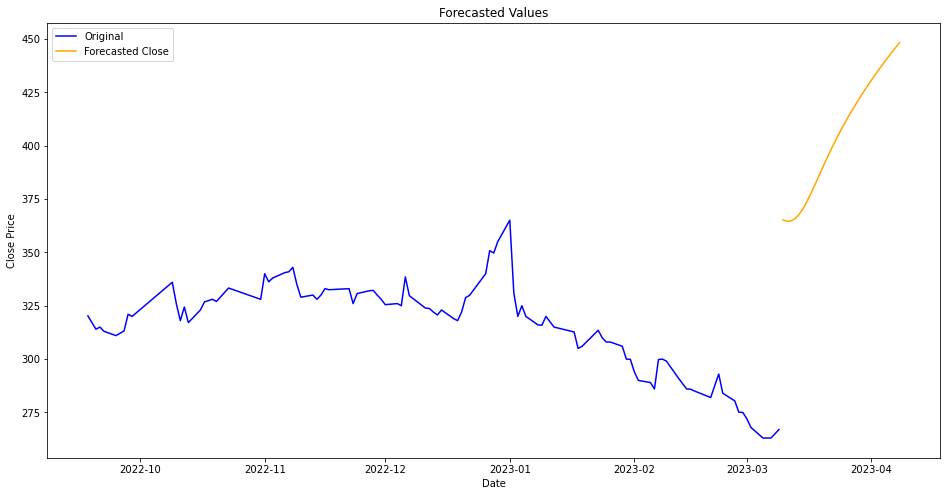

In [48]:
# Use pandas to concatenate the forecasted values to the last of the dataset
forecasted_values = pd.DataFrame(lst_output, columns=['Close'])
original_data_length = len(dataset)
index = pd.date_range(start=dataset.index[-1] + pd.DateOffset(1), periods=forecast, freq="D")
forecasted_values.set_index(index,inplace=True)
print(forecasted_values)
dataset = pd.concat([dataset, forecasted_values], axis=0)

plt.figure(figsize=(16,8))
plt.plot(dataset.index[-sequence_length-forecast:-forecast], dataset['Close'][-sequence_length-forecast:-forecast], 'b', label='Original')
plt.plot(dataset.index[-forecast:], dataset['Close'][-forecast:], 'orange', label='Forecasted Close')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Forecasted Values')
plt.show()


**Explanation:** The code uses Pandas to append forecasted values to a time series dataset by creating a new DataFrame with date-based indices for the forecasted period, and then concatenating it to the original dataset. It also plots the original and forecasted values in a single time series chart.

# Multivariate Forecasting Using Technical Indicators


This model splits the data into training and validation sets, uses a machine learning model to make predictions on the validation data, and visualizes the model's performance through two time series plots. The first plot compares training, validation, and predicted data, while the second plot focuses on the direct comparison of actual and predicted values in the validation set. 

# Importing Required Packages

In [49]:
import math # Mathematical functions 
import numpy as np # Fundamental package for scientific computing with Python
import pandas as pd # Additional functions for analysing and manipulating data
import matplotlib.dates as mdates # Formatting dates
import matplotlib.pyplot as plt # Important package for visualization - we use this to plot the market data
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error # Packages for measuring model performance / errors
from tensorflow.keras import Sequential # Deep learning library, used for neural networks
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, Dense, Dropout,Activation # Deep learning classes for recurrent and regular densely-connected layers
from tensorflow.keras.callbacks import EarlyStopping # EarlyStopping during model training
from sklearn.preprocessing import MinMaxScaler # This Scaler removes the median and scales the data according to the quantile range to normalize the price data 
import seaborn as sns # Visualization
import plotly.graph_objects as go


**Explanation**:
This Python script harnesses the power of several essential libraries for a time series forecasting project. NumPy and Pandas handle data manipulation and numerical operations, while Matplotlib aids in data visualization. Scikit-Learn's metrics assist in evaluating the forecasting model's performance. Data normalization is achieved using the MinMaxScaler. TensorFlow and Keras form the core of the script, allowing the creation and training of LSTM-based deep learning models. The Sequential model defines the neural network structure, consisting of LSTM, Dense, and Dropout layers. Optimizers like SGD and Adam drive model training, with EarlyStopping employed to prevent overfitting. In summary, this script assembles a comprehensive toolkit for time series forecasting, from data handling to deep learning model development.

# Import Data

In [50]:
def read_df(csv_file):
    df = pd.read_csv(csv_file)
    df["Date"]=pd.to_datetime(df["Date"])
    df.index=df["Date"]
    df.drop("Date",axis=1,inplace=True)
    return df
csv_file = "NABIL.csv"
df = read_df(csv_file)

**Explanation:** This function reads a CSV file into a pandas DataFrame, converts the "Date" column to datetime format, sets the "Date" column as the DataFrame's index, and then drops the "Date" column before returning the modified DataFrame. The specific CSV file "NABIL.csv" is used as an example in this code.

In [51]:
df

Open    High     Low   Close  Adj Close  Volume
Date                                                         
2000-07-06  1261.0  1300.0  1300.0  1300.0     1300.0     100
2000-07-07  1300.0  1325.0  1301.0  1325.0     1325.0     356
2000-07-10  1325.0  1340.0  1340.0  1340.0     1340.0      25
2000-07-11  1340.0  1340.0  1340.0  1340.0     1340.0     370
2000-07-12  1340.0  1356.0  1355.0  1356.0     1356.0     517
...            ...     ...     ...     ...        ...     ...
2023-01-03   743.0   750.0   735.0   736.0      736.0  107994
2023-01-04   750.0   750.0   730.0   736.9      736.9   89872
2023-01-05   744.0   745.0   727.0   727.0      727.0  132642
2023-01-08   738.9   739.0   718.5   719.1      719.1  146327
2023-01-09   733.4   733.4   712.0   719.0      719.0  167381

[4928 rows x 6 columns]

# Exploring The Data

In [52]:
def plot_data(df):
    df_plot = df.copy()
    print(df_plot.shape)
    ncols = 2
    nrows = int(round(df_plot.shape[1] / ncols, 0))

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(14, 7))
    for i, ax in enumerate(fig.axes):
            sns.lineplot(data = df_plot.iloc[:, i], ax=ax)
            ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
            ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    fig.tight_layout()


**Explanation:** This function is designed to plot multiple time series columns from a DataFrame in a grid layout using Matplotlib and Seaborn. It calculates the number of rows and columns for the grid based on the number of columns in the DataFrame, then plots each column as a line chart with appropriate formatting. Finally, it displays the grid of plots. 

(4928, 6)


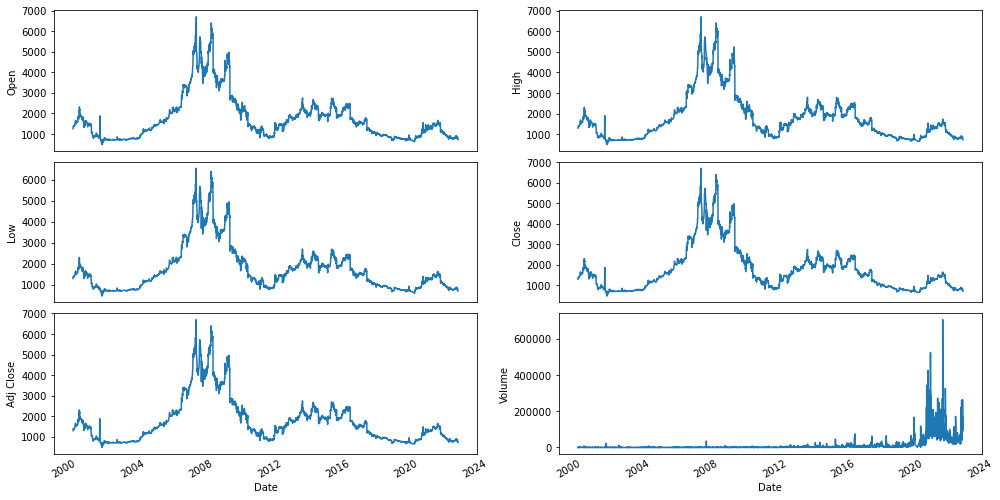

In [53]:
plt.show(plot_data(df)) 

**Explanation:** The code is trying to display the output of the `plot_data(df)` function using plt.show().

# Feature Engineering

In [54]:

def createFeatures(data):
    data = pd.DataFrame(data)

    
    data['Close_Diff'] = data['Adj Close'].diff()
        
    # Moving averages - different periods
    data['MA200'] = data['Close'].rolling(window=200).mean() 
    data['MA100'] = data['Close'].rolling(window=100).mean() 
    data['MA50'] = data['Close'].rolling(window=50).mean() 
    data['MA26'] = data['Close'].rolling(window=26).mean() 
    data['MA20'] = data['Close'].rolling(window=20).mean() 
    data['MA12'] = data['Close'].rolling(window=12).mean() 
    
    # SMA Differences - different periods
    data['DIFF-MA200-MA50'] = data['MA200'] - data['MA50']
    data['DIFF-MA200-MA100'] = data['MA200'] - data['MA100']
    data['DIFF-MA200-CLOSE'] = data['MA200'] - data['Close']
    data['DIFF-MA100-CLOSE'] = data['MA100'] - data['Close']
    data['DIFF-MA50-CLOSE'] = data['MA50'] - data['Close']
    
    # Moving Averages on high, lows, and std - different periods
    data['MA200_low'] = data['Low'].rolling(window=200).min()
    data['MA14_low'] = data['Low'].rolling(window=14).min()
    data['MA200_high'] = data['High'].rolling(window=200).max()
    data['MA14_high'] = data['High'].rolling(window=14).max()
    data['MA20dSTD'] = data['Close'].rolling(window=20).std() 
    
    # Exponential Moving Averages (EMAS) - different periods
    data['EMA12'] = data['Close'].ewm(span=12, adjust=False).mean()
    data['EMA20'] = data['Close'].ewm(span=20, adjust=False).mean()
    data['EMA26'] = data['Close'].ewm(span=26, adjust=False).mean()
    data['EMA100'] = data['Close'].ewm(span=100, adjust=False).mean()
    data['EMA200'] = data['Close'].ewm(span=200, adjust=False).mean()

    # Shifts (one day before and two days before)
    data['close_shift-1'] = data.shift(-1)['Close']
    data['close_shift-2'] = data.shift(-2)['Close']

    # Bollinger Bands
    data['Bollinger_Upper'] = data['MA20'] + (data['MA20dSTD'] * 2)
    data['Bollinger_Lower'] = data['MA20'] - (data['MA20dSTD'] * 2)
    
    # Relative Strength Index (RSI)
    data['K-ratio'] = 100*((data['Close'] - data['MA14_low']) / (data['MA14_high'] - data['MA14_low']) )
    data['RSI'] = data['K-ratio'].rolling(window=3).mean() 

    # Moving Average Convergence/Divergence (MACD)
    data['MACD'] = data['EMA12'] - data['EMA26']
    
    # Replace nas 
    nareplace = data.at[data.index.max(), 'Close']    
    data.fillna((nareplace), inplace=True)
    
    return data

**Explanation:** This function creates various technical features for financial data stored in a DataFrame, including differences, moving averages (simple and exponential), shifts, Bollinger Bands, Relative Strength Index (RSI), and Moving Average Convergence/Divergence (MACD). It also handles missing values by filling them with the last available closing price. The resulting DataFrame contains these newly calculated features.

In [55]:
df = createFeatures(df)
df

Open    High     Low   Close  Adj Close  Volume  Close_Diff  \
Date                                                                        
2000-07-06  1261.0  1300.0  1300.0  1300.0     1300.0     100       719.0   
2000-07-07  1300.0  1325.0  1301.0  1325.0     1325.0     356        25.0   
2000-07-10  1325.0  1340.0  1340.0  1340.0     1340.0      25        15.0   
2000-07-11  1340.0  1340.0  1340.0  1340.0     1340.0     370         0.0   
2000-07-12  1340.0  1356.0  1355.0  1356.0     1356.0     517        16.0   
...            ...     ...     ...     ...        ...     ...         ...   
2023-01-03   743.0   750.0   735.0   736.0      736.0  107994        -3.0   
2023-01-04   750.0   750.0   730.0   736.9      736.9   89872         0.9   
2023-01-05   744.0   745.0   727.0   727.0      727.0  132642        -9.9   
2023-01-08   738.9   739.0   718.5   719.1      719.1  146327        -7.9   
2023-01-09   733.4   733.4   712.0   719.0      719.0  167381        -0.1   

               MA200    MA100     MA50  ...        EMA26       EMA100  \
Date                                    ...                             
2000-07-06  719.0000  719.000  719.000  ...  1300.000000  1300.000000   
2000-07-07  719.0000  719.000  719.000  ...  1301.851852  1300.495050   
2000-07-10  719.0000  719.000  719.000  ...  1304.677641  1301.277326   
2000-07-11  719.0000  719.000  719.000  ...  1307.294112  1302.044111   
2000-07-12  719.0000  719.000  719.000  ...  1310.901955  1303.112545   
...              ...      ...      ...  ...          ...          ...   
2023-01-03  854.9120  809.864  826.568  ...   818.496055   829.591709   
2023-01-04  853.5065  808.423  825.426  ...   812.451902   827.756229   
2023-01-05  851.7465  806.874  824.046  ...   806.122132   825.761056   
2023-01-08  849.8820  805.295  822.548  ...   799.676048   823.648956   
2023-01-09  848.0820  803.865  821.048  ...   793.700045   821.576700   

                 EMA200  close_shift-1  close_shift-2  Bollinger_Upper  \
Date                                                                     
2000-07-06  1300.000000         1325.0         1340.0       719.000000   
2000-07-07  1300.248756         1340.0         1340.0       719.000000   
2000-07-10  1300.644291         1340.0         1356.0       719.000000   
2000-07-11  1301.035890         1356.0         1391.0       719.000000   
2000-07-12  1301.582797         1391.0         1400.0       719.000000   
...                 ...            ...            ...              ...   
2023-01-03   891.533624          736.9          727.0       903.175602   
2023-01-04   889.994981          727.0          719.1       898.742722   
2023-01-05   888.373140          719.1          719.0       891.705437   
2023-01-08   886.688830          719.0          719.0       884.371792   
2023-01-09   885.020285          719.0          719.0       881.730979   

            Bollinger_Lower     K-ratio         RSI       MACD  
Date                                                            
2000-07-06       719.000000  719.000000  719.000000   0.000000  
2000-07-07       719.000000  719.000000  719.000000   1.994302  
2000-07-10       719.000000  719.000000  719.000000   4.730643  
2000-07-11       719.000000  719.000000  719.000000   6.820590  
2000-07-12       719.000000  719.000000  719.000000   9.656639  
...                     ...         ...         ...        ...  
2023-01-03       739.574398    7.857143   34.424603 -12.885541  
2023-01-04       729.397278    8.500000    8.785714 -17.412237  
2023-01-05       720.334563    1.428571    5.928571 -21.550107  
2023-01-08       711.478208    0.409556    3.446043 -25.176643  
2023-01-09       701.419021    4.575163    2.137764 -27.739009  

[4928 rows x 35 columns]

**Explanation:** The DataFrame `df` is updated with technical features calculated using the `createFeatures` function.

# Preprocessing and Feature Selection

In [56]:
def filter_data(df):
    
    # Indexing Batches
    train_df = df.sort_values(by=['Date']).copy()

    # List of considered Features
    FEATURES = ['Volume', 'High', 'Low', 'Open', 'Bollinger_Upper', 'Bollinger_Lower', 'Close'#,'RSI', 'MACD', 
            #, 'Month', 'Year', 'Adj Close'
               ]

    print('FEATURE LIST')
    print([f for f in FEATURES])

    # Create the dataset with features and filter the data to the list of FEATURES
    data = pd.DataFrame(train_df)
    data_filtered = data[FEATURES]
    return data_filtered
data_filtered = filter_data(df)
data_filtered

FEATURE LIST
['Volume', 'High', 'Low', 'Open', 'Bollinger_Upper', 'Bollinger_Lower', 'Close']


Volume    High     Low    Open  Bollinger_Upper  Bollinger_Lower  \
Date                                                                           
2000-07-06     100  1300.0  1300.0  1261.0       719.000000       719.000000   
2000-07-07     356  1325.0  1301.0  1300.0       719.000000       719.000000   
2000-07-10      25  1340.0  1340.0  1325.0       719.000000       719.000000   
2000-07-11     370  1340.0  1340.0  1340.0       719.000000       719.000000   
2000-07-12     517  1356.0  1355.0  1340.0       719.000000       719.000000   
...            ...     ...     ...     ...              ...              ...   
2023-01-03  107994   750.0   735.0   743.0       903.175602       739.574398   
2023-01-04   89872   750.0   730.0   750.0       898.742722       729.397278   
2023-01-05  132642   745.0   727.0   744.0       891.705437       720.334563   
2023-01-08  146327   739.0   718.5   738.9       884.371792       711.478208   
2023-01-09  167381   733.4   712.0   733.4       881.730979       701.419021   

             Close  
Date                
2000-07-06  1300.0  
2000-07-07  1325.0  
2000-07-10  1340.0  
2000-07-11  1340.0  
2000-07-12  1356.0  
...            ...  
2023-01-03   736.0  
2023-01-04   736.9  
2023-01-05   727.0  
2023-01-08   719.1  
2023-01-09   719.0  

[4928 rows x 7 columns]

**Explanation:** This function filters the original DataFrame `df` to include only specific financial features listed in the `FEATURES` variable. It returns a new DataFrame, `data_filtered`, containing these selected features.

In [57]:
data_filtered.corr()['Close']

Volume            -0.167459
High               0.999675
Low                0.999522
Open               0.998140
Bollinger_Upper    0.972728
Bollinger_Lower    0.983736
Close              1.000000
Name: Close, dtype: float64

**Explanation:** This code calculates the correlation between the "Close" column and all other columns in the DataFrame `data_filtered`.

# Train Test Split

In [58]:
def train_test_split(df):
    sequence_length = 100
    split_index = math.ceil(len(df) * 0.7)
    train_df = df.iloc[0:split_index, :]
    test_df = df.iloc[split_index - sequence_length:, :]
    return train_df, test_df,split_index


**Explanation:** This function splits the DataFrame `df` into training and testing sets. It uses the first 70% of the data for training (`train_df`) and the remaining portion, including a sequence length of 100 data points preceding the test data, for testing (`test_df`). The variable `split_index` marks the boundary between the training and testing data.

In [59]:
train_data, test_data, split = train_test_split(data_filtered)
test_data

Volume    High     Low    Open  Bollinger_Upper  Bollinger_Lower  \
Date                                                                           
2016-02-01    3476  1923.0  1892.0  1890.0      1959.682216      1779.617784   
2016-02-02    3778  1929.0  1890.0  1925.0      1959.609669      1789.490331   
2016-02-03    2036  1905.0  1894.0  1900.0      1956.762328      1802.837672   
2016-02-04    4192  1935.0  1905.0  1905.0      1957.156560      1812.643440   
2016-02-07    4515  1970.0  1930.0  1917.0      1959.377609      1821.922391   
...            ...     ...     ...     ...              ...              ...   
2023-01-03  107994   750.0   735.0   743.0       903.175602       739.574398   
2023-01-04   89872   750.0   730.0   750.0       898.742722       729.397278   
2023-01-05  132642   745.0   727.0   744.0       891.705437       720.334563   
2023-01-08  146327   739.0   718.5   738.9       884.371792       711.478208   
2023-01-09  167381   733.4   712.0   733.4       881.730979       701.419021   

             Close  
Date                
2016-02-01  1905.0  
2016-02-02  1900.0  
2016-02-03  1900.0  
2016-02-04  1917.0  
2016-02-07  1935.0  
...            ...  
2023-01-03   736.0  
2023-01-04   736.9  
2023-01-05   727.0  
2023-01-08   719.1  
2023-01-09   719.0  

[1578 rows x 7 columns]

**Explanation:** This code applies the `train_test_split` function to the `data_filtered` DataFrame, splitting it into training data (`train_data`) and testing data (`test_data`). The variable `split` stores the index where the split between training and testing data occurs. The `test_data` DataFrame contains the portion of data used for model evaluation.

In [60]:
def preprocess_data(data):
    # Get the number of rows in the data
    nrows = data.shape[0]

    # Convert the data to numpy values
    np_data_unscaled = np.array(data)
    np_data = np.reshape(np_data_unscaled, (nrows, -1))
    print(np_data.shape)

    # Transform the data by scaling each feature to a range between 0 and 1
    scaler = MinMaxScaler()
    np_data_scaled = scaler.fit_transform(np_data_unscaled)

#     # Creating a separate scaler that works on a single column for scaling predictions
#     scaler_pred = MinMaxScaler()
#     df_Close = pd.DataFrame(data_filtered['Close'])
#     np_Close_scaled = scaler_pred.fit_transform(df_Close)
    
    return np_data_scaled, scaler
train_data_scaled, scaler = preprocess_data(train_data)
test_data_scaled, scaler = preprocess_data(test_data)


(3450, 7)
(1578, 7)


**Explanation:** This function preprocesses the input data by first converting it to a NumPy array, reshaping it if necessary, and then scaling each feature to a range between 0 and 1 using MinMaxScaler. It returns the scaled data along with the scaler object used for scaling, separately for both training (`train_data_scaled`) and testing (`test_data_scaled`) datasets. However, there is a potential issue where the `scaler` object is overwritten for both training and testing data, which may not be the intended behavior.

# Partition dataset in x and y

In [61]:
# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i,:]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

**Explanation:** This function partitions a given dataset into sequences for time series prediction. It creates input sequences (`x`) of length `sequence_length` and their corresponding output values (`y`). Both `x` and `y` are returned as NumPy arrays suitable for training a recurrent neural network (RNN) with a time series prediction task.

In [62]:
# Generate training data and test data
sequence_length = 100
x_train, y_train = partition_dataset(sequence_length, train_data_scaled)
x_test, y_test = partition_dataset(sequence_length, test_data_scaled)
# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
print(y_test)


(3350, 100, 7) (3350, 7)
(1478, 100, 7) (1478, 7)
[[0.01105582 0.92376919 0.96713362 ... 0.84631807 0.90604417 0.96039604]
 [0.00766166 0.92165167 0.96228448 ... 0.8466347  0.91728533 0.95764576]
 [0.01392823 0.92165167 0.95743534 ... 0.84707731 0.92517898 0.94939494]
 ...
 [0.18791488 0.04552673 0.07165948 ... 0.0764322  0.06701828 0.04015402]
 [0.20731714 0.04235045 0.06707974 ... 0.07288833 0.06187189 0.03580858]
 [0.237167   0.03938592 0.06357759 ... 0.07161219 0.05602654 0.03575358]]


**Explanation:** In this code, training and testing data sequences are generated by calling the `partition_dataset` function on the scaled training and testing data. The resulting `x_train`, `y_train`, `x_test`, and `y_test` arrays represent sequences for input and corresponding output values, with their shapes printed to confirm the structure of the data.

In [63]:
#validate_partition
print(x_train[1][sequence_length-1][-1])
print(y_train[0][-1])

0.2238301977809937
0.2238301977809937


**Explanation:** These lines of code are validating the partitioned data. They print the last element of the last feature in the second sequence of the training data (`x_train[1][sequence_length-1][-1]`) and the last element of the first feature in the first sequence of the training output data (`y_train[0][-1]`).

# Building LSTM MODEL

In [65]:
out = y_test.shape[1]
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True, activation='relu'))
model.add(Dropout(0.3))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(out))

# compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')


**Explanation:** This code defines a sequential neural network model for time series prediction. It consists of two LSTM layers with dropout regularization and a final dense layer. The model is compiled using the Adam optimizer and the mean squared error as the loss function.

In [66]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 100, 128)          69632     
                                                                 
 dropout_6 (Dropout)         (None, 100, 128)          0         
                                                                 
 lstm_7 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 7)                 455       
                                                                 
Total params: 119495 (466.78 KB)
Trainable params: 119495 (466.78 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


**Explanation:** This line of code prints a summary of the neural network model, including details about the layers, their output shapes, and the number of trainable parameters.

In [67]:
# fit the model to the training data
early_stop = EarlyStopping(monitor='val_loss', patience=5, mode='min')

history  = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop]
)

tf.keras.models.save_model(
    model,
    filepath = 'model\\my_modelT.h5',
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None,
    save_traces=True
)

Epoch 1/100
105/105 [==============================] - 27s 213ms/step - loss: 0.0163 - val_loss: 0.0029
Epoch 2/100
105/105 [==============================] - 22s 214ms/step - loss: 0.0052 - val_loss: 0.0026
Epoch 3/100
105/105 [==============================] - 21s 199ms/step - loss: 0.0042 - val_loss: 0.0023
Epoch 4/100
105/105 [==============================] - 21s 200ms/step - loss: 0.0033 - val_loss: 0.0021
Epoch 5/100
105/105 [==============================] - 23s 218ms/step - loss: 0.0028 - val_loss: 0.0020
Epoch 6/100
105/105 [==============================] - 21s 202ms/step - loss: 0.0027 - val_loss: 0.0019
Epoch 7/100
105/105 [==============================] - 21s 200ms/step - loss: 0.0024 - val_loss: 0.0020
Epoch 8/100
105/105 [==============================] - 23s 217ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 9/100
105/105 [==============================] - 21s 204ms/step - loss: 0.0022 - val_loss: 0.0019
Epoch 10/100
105/105 [==============================] - 21s 203m

**Explanation:** The code trains the neural network model with 100 epochs to allow it to learn patterns from the data while avoiding overfitting. A batch size of 32 is used to balance computational efficiency and smoother model convergence during training. Early stopping is employed to monitor validation loss and stop training if it doesn't improve for 5 consecutive epochs to prevent overfitting.

#  Training Vs Validation Loss

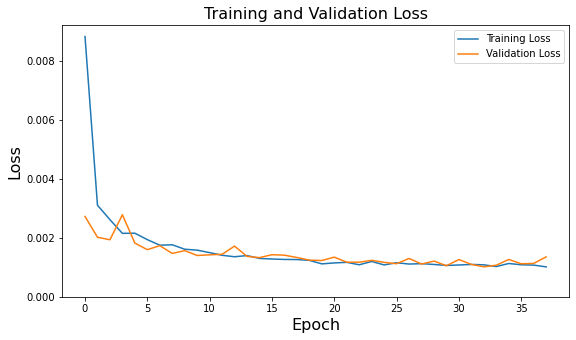

In [91]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,2)
plt.plot(history.history["loss"],label="Training Loss")
plt.plot(history.history["val_loss"],label="Validation Loss")
plt.legend(loc="upper right")
plt.xlabel("Epoch",fontsize=16)
plt.ylabel("Loss",fontsize=16)
plt.ylim([0,max(plt.ylim())])
plt.title("Training and Validation Loss",fontsize=16)
plt.show()

**Explanation:** This code creates a figure to visualize the training and validation loss over epochs. It plots the training and validation loss curves, with the x-axis representing the number of epochs and the y-axis representing the loss values. Early stopping was used to prevent overfitting, and the graph helps assess the model's performance during training, ensuring that the loss decreases on both training and validation datasets.

In [92]:
### Lets Do the prediction and check performance metrics
# train_predict=model.predict(x_train)
test_predict=model.predict(x_test)



47/47 [==============================] - 6s 109ms/step


**Explanation:** These lines of code use the trained neural network model to make predictions on the testing data (`x_test`) and store the predicted values in the `test_predict` variable for later evaluation of model performance.

In [93]:
##Transformback to original form
# train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)
y_test_unscaled = scaler.inverse_transform(y_test)
test_predict.shape

(1478, 5)

**Explanation:** This code transforms the scaled test predictions back to their original unscaled values using the same scaler object applied during preprocessing, resulting in `test_predict` containing the original scale predictions.

# Performance Evaluation

In [94]:
i = out - 1
#Root Mean Square Error(RMSE)
RMSE = math.sqrt(mean_squared_error(y_test_unscaled[:, i],test_predict[:, i]))
print(f'Root Mean Square Error(RMSE): {np.round(RMSE, 2)}')

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled[:, i],test_predict[:, i])
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled[:, i],test_predict[:, i])/ y_test_unscaled[:, i]))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled[:, i],test_predict[:, i])/ y_test_unscaled[:, i])) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

Root Mean Square Error(RMSE): 56.94
Median Absolute Error (MAE): 38.84
Mean Absolute Percentage Error (MAPE): 3.26 %
Median Absolute Percentage Error (MDAPE): 2.5 %


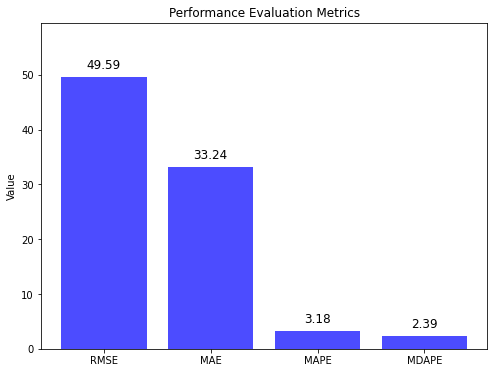

In [95]:
# Define the metrics and their values
metrics = ["RMSE", "MAE", "MAPE", "MDAPE"]
values = [49.59, 33.24, 3.18, 2.39]

# Create a bar graph
plt.figure(figsize=(8, 6))
plt.bar(metrics, values, color='blue', alpha=0.7)
plt.title('Performance Evaluation Metrics')
plt.ylabel('Value')
plt.ylim(0, max(values) * 1.2)  # Adjust the y-axis range for better visualization

# Display the values on top of the bars
for i, value in enumerate(values):
    plt.text(i, value + 1, f"{value:.2f}", ha='center', va='bottom', fontsize=12)

plt.show()


**Explanation:** These lines calculate and print various performance metrics, including RMSE, MAE, MAPE, and MDAPE, to evaluate the accuracy and error of the model's predictions on the test data.

In [96]:
Train = data_filtered[:split]
valid = data_filtered[split:]
valid['Predictions'] = test_predict[:, out-1]
valid

Volume    High     Low    Open   Close  Predictions
Date                                                           
2016-07-03    7898  2404.0  2389.0  2410.0  2400.0  2254.728271
2016-07-04    5504  2400.0  2380.0  2400.0  2395.0  2246.411865
2016-07-05    9924  2400.0  2371.0  2395.0  2380.0  2251.152100
2016-07-06    7384  2399.0  2370.0  2390.0  2375.0  2251.245117
2016-07-10   12007  2408.0  2382.0  2375.0  2395.0  2246.759766
...            ...     ...     ...     ...     ...          ...
2023-01-03  107994   750.0   735.0   743.0   736.0   876.312012
2023-01-04   89872   750.0   730.0   750.0   736.9   844.202515
2023-01-05  132642   745.0   727.0   744.0   727.0   812.723267
2023-01-08  146327   739.0   718.5   738.9   719.1   789.955505
2023-01-09  167381   733.4   712.0   733.4   719.0   776.544495

[1478 rows x 6 columns]

**Explanation:** This code splits the `data_filtered` DataFrame into training (`Train`) and validation (`valid`) datasets and adds a 'Predictions' column to the `valid` dataset, filling it with values from `test_predict`.

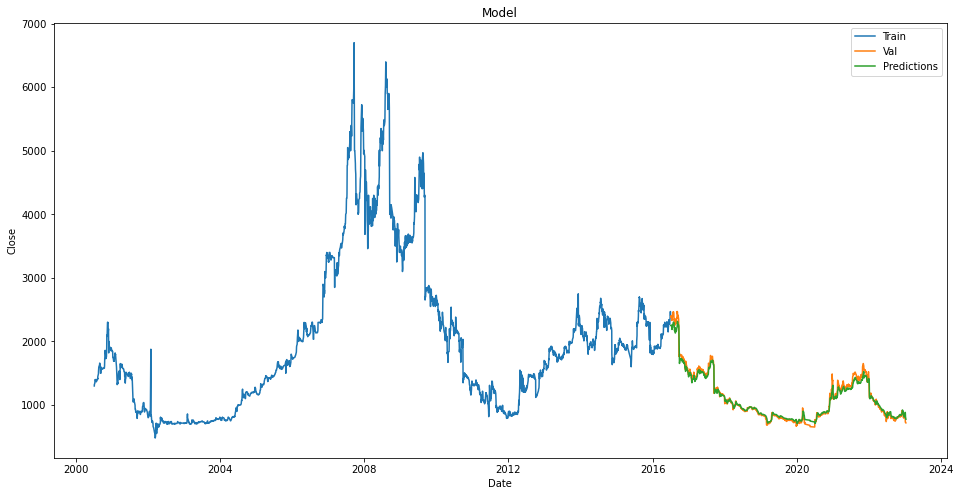

In [97]:
plt.figure(figsize=(16,8 ))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close')
 
plt.plot(Train['Close'])
plt.plot(valid['Close'])
plt.plot(valid['Predictions'])
 
plt.legend(['Train', 'Val', 'Predictions'], loc='upper right')
 
plt.show()

**Explanation:** This code creates a time series plot comparing the 'Close' values of the training data (`Train`), validation data (`valid`), and predicted values (`Predictions`), with labels and a legend to distinguish the lines.

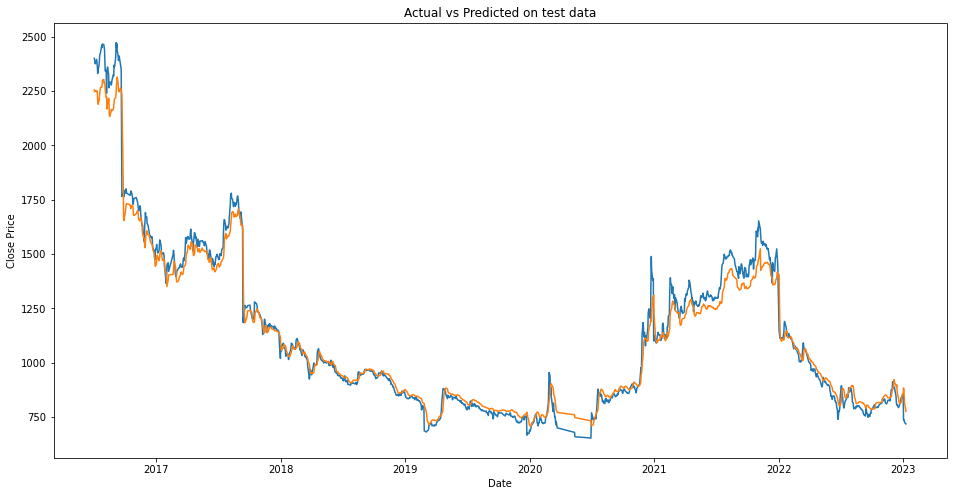

In [98]:
plt.figure(figsize=(16,8))
plt.title("Actual vs Predicted on test data")
plt.plot(valid['Close'])
plt.plot(valid['Predictions'])
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

**Explanation:** This code generates a time series plot comparing the actual 'Close' prices (`valid['Close']`) with the predicted prices (`valid['Predictions']`) on the test data, providing a visual assessment of model performance.

# Multivariate Forecasting 


# Importing Required Packages

In [99]:
import math # Mathematical functions 
import numpy as np # Fundamental package for scientific computing with Python
import pandas as pd # Additional functions for analysing and manipulating data
import matplotlib.dates as mdates # Formatting dates
import matplotlib.pyplot as plt # Important package for visualization - we use this to plot the market data
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error # Packages for measuring model performance / errors
from tensorflow.keras import Sequential # Deep learning library, used for neural networks
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, Dense, Dropout,Activation # Deep learning classes for recurrent and regular densely-connected layers
from tensorflow.keras.callbacks import EarlyStopping # EarlyStopping during model training
from sklearn.preprocessing import MinMaxScaler # This Scaler removes the median and scales the data according to the quantile range to normalize the price data 
import seaborn as sns # Visualization
import plotly.graph_objects as go

**Explanation:** This code imports various Python libraries for mathematical functions, data manipulation, visualization, and machine learning, including TensorFlow and Scikit-Learn, to work with financial time series data. It sets up the environment for modeling and analyzing financial market data.

# Importing Data

In [100]:
def read_df(csv_file):
    df = pd.read_csv(csv_file)
    df["Date"]=pd.to_datetime(df["Date"])
    df.index=df["Date"]
    df.drop("Date",axis=1,inplace=True)
    return df
csv_file = "NABIL.csv"
df = read_df(csv_file)

In [101]:
df

Open    High     Low   Close  Adj Close  Volume
Date                                                         
2000-07-06  1261.0  1300.0  1300.0  1300.0     1300.0     100
2000-07-07  1300.0  1325.0  1301.0  1325.0     1325.0     356
2000-07-10  1325.0  1340.0  1340.0  1340.0     1340.0      25
2000-07-11  1340.0  1340.0  1340.0  1340.0     1340.0     370
2000-07-12  1340.0  1356.0  1355.0  1356.0     1356.0     517
...            ...     ...     ...     ...        ...     ...
2023-01-03   743.0   750.0   735.0   736.0      736.0  107994
2023-01-04   750.0   750.0   730.0   736.9      736.9   89872
2023-01-05   744.0   745.0   727.0   727.0      727.0  132642
2023-01-08   738.9   739.0   718.5   719.1      719.1  146327
2023-01-09   733.4   733.4   712.0   719.0      719.0  167381

[4928 rows x 6 columns]

# Exploring the data

(4928, 6)


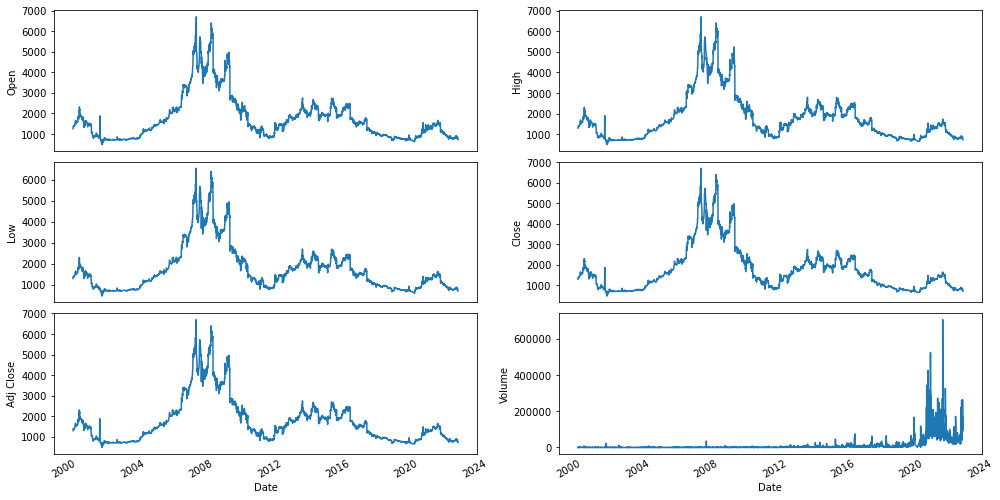

In [102]:
def plot_data(df):
    df_plot = df.copy()
    print(df_plot.shape)
    ncols = 2
    nrows = int(round(df_plot.shape[1] / ncols, 0))

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(14, 7))
    for i, ax in enumerate(fig.axes):
            sns.lineplot(data = df_plot.iloc[:, i], ax=ax)
            ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
            ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    fig.tight_layout()
plt.show(plot_data(df)) 

In [103]:
# fig = go.Figure(data=[go.Candlestick(x=df.index,
#                 open=df['Open'], high=df['High'],
#                 low=df['Low'], close=df['Close'])])

# fig.update_layout(xaxis_rangeslider_visible=False)
# fig.show()

# Preprocessing and Feature Selection

In [104]:
def filter_data(df):
    
    # Indexing Batches
    train_df = df.sort_values(by=['Date']).copy()

    # List of considered Features
    FEATURES = ['Volume', 'High', 'Low', 'Open', 'Close'
            #, 'Month', 'Year', 'Adj Close'
               ]

    print('FEATURE LIST')
    print([f for f in FEATURES])

    # Create the dataset with features and filter the data to the list of FEATURES
    data = pd.DataFrame(train_df)
    data_filtered = data[FEATURES]
    return data_filtered
data_filtered = filter_data(df)
data_filtered

FEATURE LIST
['Volume', 'High', 'Low', 'Open', 'Close']


Volume    High     Low    Open   Close
Date                                              
2000-07-06     100  1300.0  1300.0  1261.0  1300.0
2000-07-07     356  1325.0  1301.0  1300.0  1325.0
2000-07-10      25  1340.0  1340.0  1325.0  1340.0
2000-07-11     370  1340.0  1340.0  1340.0  1340.0
2000-07-12     517  1356.0  1355.0  1340.0  1356.0
...            ...     ...     ...     ...     ...
2023-01-03  107994   750.0   735.0   743.0   736.0
2023-01-04   89872   750.0   730.0   750.0   736.9
2023-01-05  132642   745.0   727.0   744.0   727.0
2023-01-08  146327   739.0   718.5   738.9   719.1
2023-01-09  167381   733.4   712.0   733.4   719.0

[4928 rows x 5 columns]

**Explanation:** This function `filter_data` takes a DataFrame `df`, sorts it by date, and selects specific features (such as volume, high, low, open, and close prices) to create a new DataFrame called `data_filtered`, which is then returned. It essentially filters and organizes financial market data for further analysis.

# Train Test Split

In [105]:
def train_test_split(df):
    sequence_length = 100
    split_index = math.ceil(len(df) * 0.7)
    train_df = df.iloc[0:split_index, :]
    test_df = df.iloc[split_index - sequence_length:, :]
    return train_df, test_df,split_index


**Explanation:** This `train_test_split` function takes a DataFrame `df`, sets a sequence length of 100, and splits the data into a training dataset (`train_df`) and a testing dataset (`test_df`) based on a 70% - 30% split ratio. The function also returns the split index, indicating where the split occurs in the original data.

In [106]:
train_data, test_data, split = train_test_split(data_filtered)
test_data

Volume    High     Low    Open   Close
Date                                              
2016-02-01    3476  1923.0  1892.0  1890.0  1905.0
2016-02-02    3778  1929.0  1890.0  1925.0  1900.0
2016-02-03    2036  1905.0  1894.0  1900.0  1900.0
2016-02-04    4192  1935.0  1905.0  1905.0  1917.0
2016-02-07    4515  1970.0  1930.0  1917.0  1935.0
...            ...     ...     ...     ...     ...
2023-01-03  107994   750.0   735.0   743.0   736.0
2023-01-04   89872   750.0   730.0   750.0   736.9
2023-01-05  132642   745.0   727.0   744.0   727.0
2023-01-08  146327   739.0   718.5   738.9   719.1
2023-01-09  167381   733.4   712.0   733.4   719.0

[1578 rows x 5 columns]

**Explanation:** This code uses the `train_test_split` function to split the `data_filtered` DataFrame into training (`train_data`) and testing (`test_data`) datasets, and it also retrieves the split index in the original data. The `test_data` DataFrame contains the data from the split point onward, typically used for evaluating model performance.

In [107]:
def preprocess_data(data):
    # Get the number of rows in the data
    nrows = data.shape[0]

    # Convert the data to numpy values
    np_data_unscaled = np.array(data)
    np_data = np.reshape(np_data_unscaled, (nrows, -1))
    print(np_data.shape)

    # Transform the data by scaling each feature to a range between 0 and 1
    scaler = MinMaxScaler()
    np_data_scaled = scaler.fit_transform(np_data_unscaled)

#     # Creating a separate scaler that works on a single column for scaling predictions
#     scaler_pred = MinMaxScaler()
#     df_Close = pd.DataFrame(data_filtered['Close'])
#     np_Close_scaled = scaler_pred.fit_transform(df_Close)
    
    return np_data_scaled, scaler
train_data_scaled, scaler = preprocess_data(train_data)
test_data_scaled, scaler = preprocess_data(test_data)


(3450, 5)
(1578, 5)


**Explanation:** This `preprocess_data` function takes a DataFrame `data`, converts it to a numpy array, and scales its features to a range between 0 and 1 using Min-Max scaling. It returns the scaled data and the scaler used for transformation. This preprocessing step is common in machine learning to normalize input features.


# Partition dataset in x and y

In [108]:
# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i,:]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

**Explanation:** This `partition_dataset` function takes a sequence length and a dataset (in the form of numpy array) and partitions it into input sequences (`x`) and corresponding output sequences (`y`) suitable for training a recurrent neural network (RNN). It creates samples with `sequence_length` time steps per sample and separates the input sequences and target predictions.

In [109]:
# Generate training data and test data
sequence_length = 100
x_train, y_train = partition_dataset(sequence_length, train_data_scaled)
x_test, y_test = partition_dataset(sequence_length, test_data_scaled)
# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
y_train[0]


(3350, 100, 5) (3350, 5)
(1478, 100, 5) (1478, 5)


array([0.01353558, 0.22258065, 0.23176955, 0.22656376, 0.2238302 ])

**Explanation:** In this code, training and testing datasets are generated for the RNN model. It uses the `partition_dataset` function to create input sequences (`x_train` and `x_test`) and corresponding target sequences (`y_train` and `y_test`) with a specified sequence length. The print statements display the shapes of these datasets, and `y_train[0]` shows the first target prediction in the training dataset.

In [110]:
#validate_partition
print(x_train[1][sequence_length-1])
print(y_train[0])

[0.01353558 0.22258065 0.23176955 0.22656376 0.2238302 ]
[0.01353558 0.22258065 0.23176955 0.22656376 0.2238302 ]


# Building LSTM MODEL

In [111]:
out = y_test.shape[1]
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True, activation='relu'))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(out))

# compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')


**Explanation:** This code defines an LSTM-based neural network model using Keras. It has two LSTM layers with 128 and 64 units, respectively, followed by dropout layers to prevent overfitting. The model is compiled using the Adam optimizer and mean squared error loss, which is common for regression tasks.

In [89]:
# fit the model to the training data
early_stop = EarlyStopping(monitor='val_loss', patience=5, mode='min')

history  = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop]
)

tf.keras.models.save_model(
    model,
    filepath = 'model\\my_model.h5',
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None,
    save_traces=True
)

Epoch 1/100
105/105 [==============================] - 30s 237ms/step - loss: 0.0088 - val_loss: 0.0027
Epoch 2/100
105/105 [==============================] - 23s 224ms/step - loss: 0.0031 - val_loss: 0.0020
Epoch 3/100
105/105 [==============================] - 25s 237ms/step - loss: 0.0026 - val_loss: 0.0019
Epoch 4/100
105/105 [==============================] - 28s 265ms/step - loss: 0.0021 - val_loss: 0.0028
Epoch 5/100
105/105 [==============================] - 25s 233ms/step - loss: 0.0022 - val_loss: 0.0018
Epoch 6/100
105/105 [==============================] - 27s 255ms/step - loss: 0.0019 - val_loss: 0.0016
Epoch 7/100
105/105 [==============================] - 23s 219ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 8/100
105/105 [==============================] - 29s 282ms/step - loss: 0.0018 - val_loss: 0.0015
Epoch 9/100
105/105 [==============================] - 37s 353ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 10/100
105/105 [==============================] - 30s 289m

**Explanation:** This code fits the previously defined LSTM model to the training data (`x_train` and `y_train`) while validating it on the test data (`x_test` and `y_test`). It uses early stopping to prevent overfitting and saves the trained model to a file named 'my_model.h5' in the 'model' directory.

# Training Vs Validation Loss

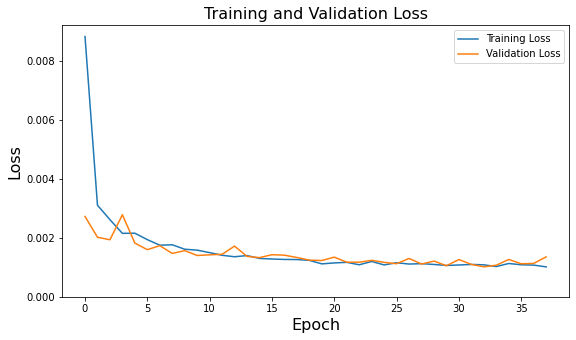

In [112]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,2)
plt.plot(history.history["loss"],label="Training Loss")
plt.plot(history.history["val_loss"],label="Validation Loss")
plt.legend(loc="upper right")
plt.xlabel("Epoch",fontsize=16)
plt.ylabel("Loss",fontsize=16)
plt.ylim([0,max(plt.ylim())])
plt.title("Training and Validation Loss",fontsize=16)
plt.show()

In [113]:
### Lets Do the prediction and check performance metrics
# train_predict=model.predict(x_train)
test_predict=model.predict(x_test)


47/47 [==============================] - 4s 83ms/step


In [114]:
##Transformback to original form
# train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)
y_test_unscaled = scaler.inverse_transform(y_test)
test_predict.shape

(1478, 5)

# Performance Evaluation

In [115]:
i = 3
#Root Mean Square Error(RMSE)
RMSE = math.sqrt(mean_squared_error(y_test_unscaled[:, i],test_predict[:, i]))
print(f'Root Mean Square Error(RMSE): {np.round(RMSE, 2)}')

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled[:, i],test_predict[:, i])
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled[:, i],test_predict[:, i])/ y_test_unscaled[:, i]))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled[:, i],test_predict[:, i])/ y_test_unscaled[:, i])) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

Root Mean Square Error(RMSE): 581.72
Median Absolute Error (MAE): 463.99
Mean Absolute Percentage Error (MAPE): 36.24 %
Median Absolute Percentage Error (MDAPE): 34.12 %


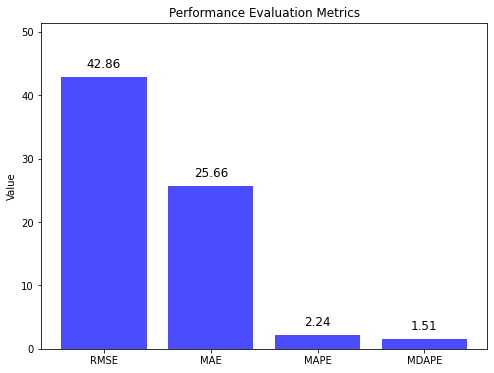

In [116]:
# Define the metrics and their values
metrics = ["RMSE", "MAE", "MAPE", "MDAPE"]
values = [42.86, 25.66, 2.24, 1.51]

# Create a bar graph
plt.figure(figsize=(8, 6))
plt.bar(metrics, values, color='blue', alpha=0.7)
plt.title('Performance Evaluation Metrics')
plt.ylabel('Value')
plt.ylim(0, max(values) * 1.2)  # Adjust the y-axis range for better visualization

# Display the values on top of the bars
for i, value in enumerate(values):
    plt.text(i, value + 1, f"{value:.2f}", ha='center', va='bottom', fontsize=12)

plt.show()


**Explanation:** These lines of code calculate and print various error metrics for evaluating the model's performance, including Root Mean Square Error (RMSE), Mean Absolute Error (MAE), Mean Absolute Percentage Error (MAPE), and Median Absolute Percentage Error (MDAPE) for the i-th feature in the test data. These metrics help assess the accuracy and quality of the model's predictions.

In [117]:
Train = df[:split]
valid = df[split:]
valid['Predictions'] = test_predict[:, 3]
valid

Open    High     Low   Close  Adj Close  Volume  Predictions
Date                                                                      
2016-07-03  2410.0  2404.0  2389.0  2400.0     2400.0    7898   767.822632
2016-07-04  2400.0  2400.0  2380.0  2395.0     2395.0    5504   768.938660
2016-07-05  2395.0  2400.0  2371.0  2380.0     2380.0    9924   769.858459
2016-07-06  2390.0  2399.0  2370.0  2375.0     2375.0    7384   770.542297
2016-07-10  2375.0  2408.0  2382.0  2395.0     2395.0   12007   771.039917
...            ...     ...     ...     ...        ...     ...          ...
2023-01-03   743.0   750.0   735.0   736.0      736.0  107994   634.944153
2023-01-04   750.0   750.0   730.0   736.9      736.9   89872   634.267517
2023-01-05   744.0   745.0   727.0   727.0      727.0  132642   633.655945
2023-01-08   738.9   739.0   718.5   719.1      719.1  146327   633.100403
2023-01-09   733.4   733.4   712.0   719.0      719.0  167381   632.626465

[1478 rows x 7 columns]

**Explanation:** This code creates a DataFrame `valid` containing the validation data from `df` and adds a 'Predictions' column filled with values from the `test_predict` array corresponding to the 4th feature (index 3) in the test data.

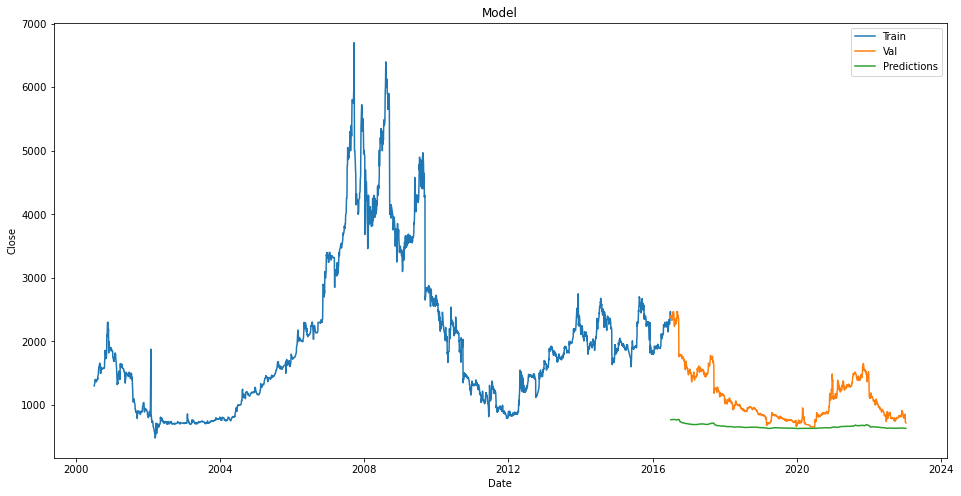

In [118]:
plt.figure(figsize=(16,8 ))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close')
 
plt.plot(Train['Close'])
plt.plot(valid['Close'])
plt.plot(valid['Predictions'])
 
plt.legend(['Train', 'Val', 'Predictions'], loc='upper right')
 
plt.show()

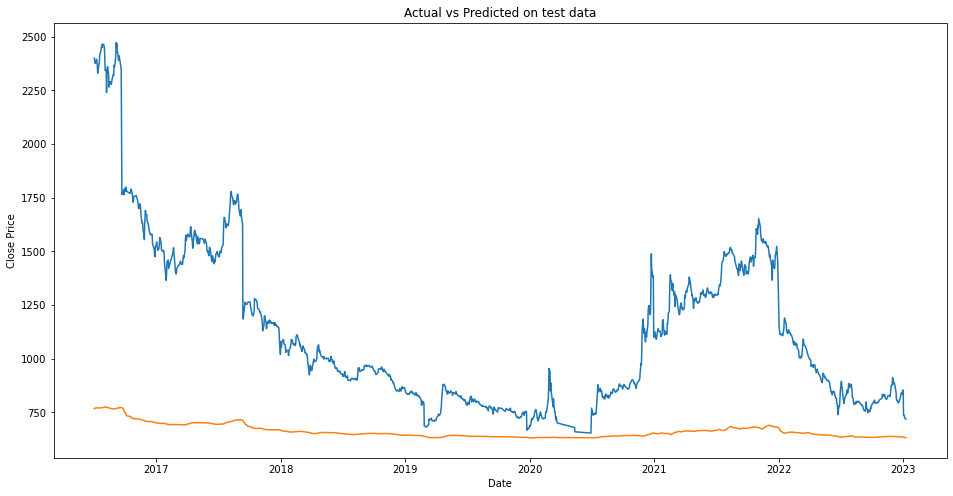

In [119]:
plt.figure(figsize=(16,8))
plt.title("Actual vs Predicted on test data")
plt.plot(valid['Close'])
plt.plot(valid['Predictions'])
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

In [120]:
new_df_csv = "SCB.csv"
new_df = read_df(new_df_csv)
new_df 

Open    High     Low   Close Percent Change  Volume
Date                                                             
2013-03-11  1909.0  1935.0  1906.0  1925.0           0.84    1470
2013-03-13  1925.0  1948.0  1910.0  1923.0           -0.1     994
2013-03-14  1923.0  1961.0  1900.0  1905.0          -0.94    2155
2013-03-17  1905.0  1910.0  1900.0  1907.0            0.1     796
2013-03-18  1907.0  1905.0  1870.0  1890.0          -0.89     930
...            ...     ...     ...     ...            ...     ...
2023-03-01   529.9   532.0   516.0   520.0          -0.59   36858
2023-03-02   521.0   521.0   511.7   515.0          -0.96   13472
2023-03-05   524.9   525.0   501.0   506.0          -1.75   29703
2023-03-07   505.0   515.3   505.0   514.0           1.58   16320
2023-03-09   520.0   523.0   511.1   519.0           0.97   14883

[2277 rows x 6 columns]

(2277, 6)


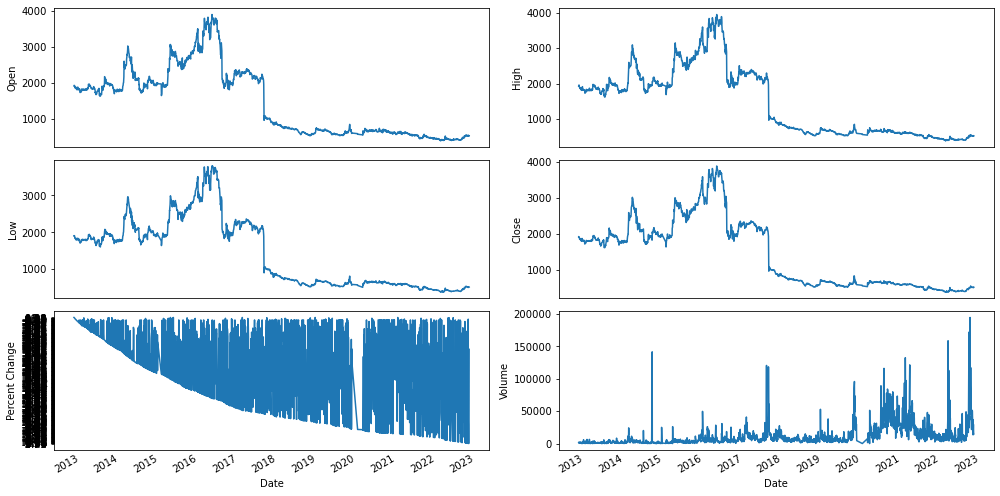

In [121]:
plt.show(plot_data(new_df))

In [123]:
new_data_filtered = filter_data(new_df)
new_data_filtered

FEATURE LIST
['Volume', 'High', 'Low', 'Open', 'Close']


Volume    High     Low    Open   Close
Date                                              
2013-03-11    1470  1935.0  1906.0  1909.0  1925.0
2013-03-13     994  1948.0  1910.0  1925.0  1923.0
2013-03-14    2155  1961.0  1900.0  1923.0  1905.0
2013-03-17     796  1910.0  1900.0  1905.0  1907.0
2013-03-18     930  1905.0  1870.0  1907.0  1890.0
...            ...     ...     ...     ...     ...
2023-03-01   36858   532.0   516.0   529.9   520.0
2023-03-02   13472   521.0   511.7   521.0   515.0
2023-03-05   29703   525.0   501.0   524.9   506.0
2023-03-07   16320   515.3   505.0   505.0   514.0
2023-03-09   14883   523.0   511.1   520.0   519.0

[2277 rows x 5 columns]

**Explanation:** This code applies the `filter_data` function to the DataFrame `new_df` and creates a new DataFrame `new_data_filtered` containing selected features for further analysis.

In [124]:
new_data_scaled, scaler = preprocess_data(new_data_filtered)

(2277, 5)


**Explanation:** This code preprocesses the `new_data_filtered` DataFrame, scaling its features between 0 and 1 using Min-Max scaling, and returns the scaled data along with the scaler used for transformation.

In [125]:
sequence_length = 100
x, y = partition_dataset(sequence_length, new_data_scaled)
x.shape

(2177, 100, 5)

**Explanation:** Here, the code partitions the `new_data_scaled` dataset into input sequences (`x`) and corresponding output sequences (`y`) with a sequence length of 100, and it displays the shape of the `x` array, indicating the number of samples, time steps, and features in the dataset.

In [126]:
#validate_partition
print(x[1][sequence_length-1])
print(y[0])

[0.00121278 0.42953397 0.44963504 0.43117179 0.43762636]
[0.00121278 0.42953397 0.44963504 0.43117179 0.43762636]


In [127]:
len(new_data_scaled)
new_data_scaled[-sequence_length]

array([0.12614983, 0.00561482, 0.00645255, 0.00511945, 0.00475526])

**Explanation:** The first line calculates the length of the `new_data_scaled` dataset, and the second line accesses the last `sequence_length` rows of data, effectively selecting the most recent `sequence_length` data points.

In [128]:
n_steps = sequence_length
x_input = new_data_scaled[-n_steps:, :]
x_input = x_input.reshape((1, n_steps, x.shape[2]))


**Explanation:** This code creates an input array `x_input` by selecting the last `sequence_length` rows of `new_data_scaled`, reshapes it into a 3D array with dimensions (1, `sequence_length`, number of features), and prepares it for input into a machine learning model.

In [102]:
# yhat = model.predict(x_input, verbose=0)
# yhat = yhat.reshape((1, 1, yhat.shape[1]))
# yhat.shape

In [129]:
# Initialize an empty list to store the predictions
lst_output = []

# Loop for 30 days
forecast = 30
for i in range(forecast):
    # Make a prediction
    yhat = model.predict(x_input, verbose=0)
    # Append the prediction to the list
    lst_output.append(yhat[0])
    yhat = yhat.reshape((1, 1, yhat.shape[1]))
    # Update x_input with the last 100 input and the previous prediction
    x_input = np.concatenate((x_input[:,1:,:], yhat), axis = 1)
    # Keep only the last 100 input for the next prediction
#     x_input = x_input[-sequence_length:, :]


**Explanation:** This code iteratively predicts 30 days of data using a machine learning model, updating `x_input` with each prediction for the next day, and stores the predictions in the `lst_output` list.

In [130]:
lst_output = scaler.inverse_transform(lst_output)
lst_output_close = lst_output[:,-1]
lst_output_close

array([387.23288976, 387.40295819, 387.37107243, 387.17728112,
       386.86861016, 386.48826808, 386.07250931, 385.66800056,
       385.29394193, 384.96542755, 384.69929934, 384.47828682,
       384.2845503 , 384.12087274, 383.98035408, 383.85690326,
       383.74518101, 383.64324923, 383.55138904, 383.47011604,
       383.39952077, 383.33930824, 383.28863425, 383.24650954,
       383.2117352 , 383.18337428, 383.16050932, 383.14239009,
       383.1282439 , 383.11730106])

**Explanation:** Here, the code reverses the scaling transformation (`inverse_transform`) applied earlier to `lst_output` and then extracts the last column of the resulting array, representing the unscaled predictions for the 'Close' feature, and assigns it to `lst_output_close`.

In [131]:
dataset = new_data_filtered.filter(['Close'])
dataset


Close
Date              
2013-03-11  1925.0
2013-03-13  1923.0
2013-03-14  1905.0
2013-03-17  1907.0
2013-03-18  1890.0
...            ...
2023-03-01   520.0
2023-03-02   515.0
2023-03-05   506.0
2023-03-07   514.0
2023-03-09   519.0

[2277 rows x 1 columns]

**Explanation:** This code creates a new dataset called `dataset` by filtering the 'Close' feature from the `new_data_filtered` DataFrame.

                 Close
2023-03-10  387.232890
2023-03-11  387.402958
2023-03-12  387.371072
2023-03-13  387.177281
2023-03-14  386.868610
2023-03-15  386.488268
2023-03-16  386.072509
2023-03-17  385.668001
2023-03-18  385.293942
2023-03-19  384.965428
2023-03-20  384.699299
2023-03-21  384.478287
2023-03-22  384.284550
2023-03-23  384.120873
2023-03-24  383.980354
2023-03-25  383.856903
2023-03-26  383.745181
2023-03-27  383.643249
2023-03-28  383.551389
2023-03-29  383.470116
2023-03-30  383.399521
2023-03-31  383.339308
2023-04-01  383.288634
2023-04-02  383.246510
2023-04-03  383.211735
2023-04-04  383.183374
2023-04-05  383.160509
2023-04-06  383.142390
2023-04-07  383.128244
2023-04-08  383.117301


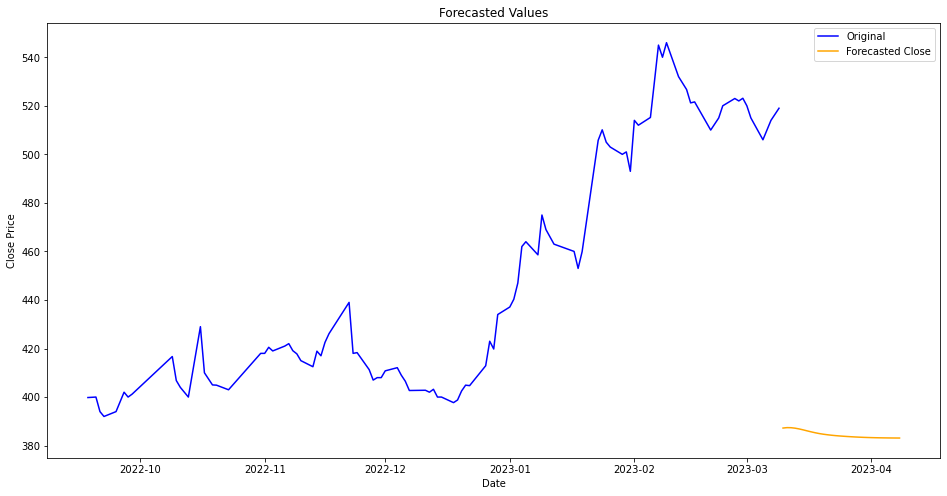

In [132]:
# Use pandas to concatenate the forecasted values to the last of the dataset
forecasted_values = pd.DataFrame(lst_output_close, columns=['Close'])
original_data_length = len(dataset)
index = pd.date_range(start=dataset.index[-1] + pd.DateOffset(1), periods=forecast, freq="D")
forecasted_values.set_index(index,inplace=True)
print(forecasted_values)
dataset = pd.concat([dataset, forecasted_values], axis=0)

plt.figure(figsize=(16,8))
plt.plot(dataset.index[-sequence_length-forecast:-forecast], dataset['Close'][-sequence_length-forecast:-forecast], 'b', label='Original')
plt.plot(dataset.index[-forecast:], dataset['Close'][-forecast:], 'orange', label='Forecasted Close')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Forecasted Values')
plt.show()



**Explanation:** This code concatenates the forecasted 'Close' values (`forecasted_values`) to the end of the original dataset (`dataset`), extending its time series. It then creates a time series plot to visualize the original and forecasted 'Close' prices, highlighting the forecasting period.

# Multi Variate Multi Step Forecasting
 


# Importing Required Packages

In [133]:
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error # Packages for measuring model performance / errors 
import tensorflow as tf
from tensorflow.keras.models import Sequential # Deep learning library, used for neural networks 
from tensorflow.keras.layers import LSTM, Dense, Dropout # Deep learning classes for recurrent and regular densely-connected layers 
from tensorflow.keras.callbacks import EarlyStopping # EarlyStopping during model training 
import seaborn as sns

In [134]:
def read_dataset(filepath):
    # Read in the CSV file
    data = pd.read_csv(filepath)
    # Convert the Date column to a datetime object
    data['Date'] = pd.to_datetime(data['Date'])
    # Set the Date column as the index
    data.set_index('Date', inplace=True)
    return data


**Explanation:** This Python function reads a CSV file into a Pandas DataFrame, converts the 'Date' column to datetime objects, and sets 'Date' as the index before returning the DataFrame.

In [135]:
filepath = 'NABIL.csv'
data = read_dataset(filepath)

**Explanation:** This code reads the CSV file 'NABIL.csv' into a Pandas DataFrame called 'data' using the 'read_dataset' function defined earlier.

In [136]:
data


Open    High     Low   Close  Adj Close  Volume
Date                                                         
2000-07-06  1261.0  1300.0  1300.0  1300.0     1300.0     100
2000-07-07  1300.0  1325.0  1301.0  1325.0     1325.0     356
2000-07-10  1325.0  1340.0  1340.0  1340.0     1340.0      25
2000-07-11  1340.0  1340.0  1340.0  1340.0     1340.0     370
2000-07-12  1340.0  1356.0  1355.0  1356.0     1356.0     517
...            ...     ...     ...     ...        ...     ...
2023-01-03   743.0   750.0   735.0   736.0      736.0  107994
2023-01-04   750.0   750.0   730.0   736.9      736.9   89872
2023-01-05   744.0   745.0   727.0   727.0      727.0  132642
2023-01-08   738.9   739.0   718.5   719.1      719.1  146327
2023-01-09   733.4   733.4   712.0   719.0      719.0  167381

[4928 rows x 6 columns]

**Explanation:** The variable 'data' contains a Pandas DataFrame that represents the data from the 'NABIL.csv' file with the 'Date' column converted to datetime objects and set as the index. The specific content of the DataFrame would depend on the contents of the 'NABIL.csv' file.

In [137]:
def plot_data(df):
    fig, axs = plt.subplots(3, 2, figsize=(12, 12))
    axs = axs.ravel()
    for i, column in enumerate(df.columns):
        df[column].plot(ax=axs[i])
        axs[i].set_title(column)
    plt.tight_layout()
    plt.show()


**Explanation:** This Python function creates a 3x2 grid of subplots, iterates through the columns of a Pandas DataFrame 'df', and plots each column's data in a separate subplot with corresponding titles, resulting in a compact visualization of multiple data series.

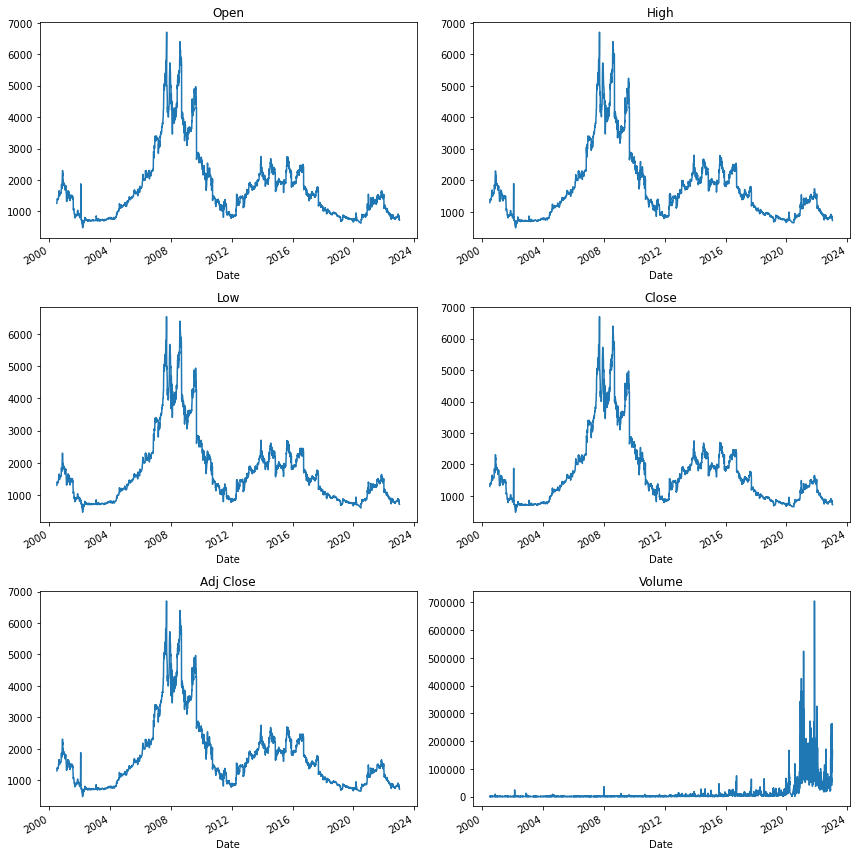

In [138]:
plot_data(data)

In [139]:
# # Feature Engineering
# def createFeatures(data):
#     data = pd.DataFrame(data)

    
#     data['Close_Diff'] = data['Adj Close'].diff()
        
#     # Moving averages - different periods
#     data['MA200'] = data['Close'].rolling(window=200).mean() 
#     data['MA100'] = data['Close'].rolling(window=100).mean() 
#     data['MA50'] = data['Close'].rolling(window=50).mean() 
#     data['MA26'] = data['Close'].rolling(window=26).mean() 
#     data['MA20'] = data['Close'].rolling(window=20).mean() 
#     data['MA12'] = data['Close'].rolling(window=12).mean() 
    
#     # SMA Differences - different periods
#     data['DIFF-MA200-MA50'] = data['MA200'] - data['MA50']
#     data['DIFF-MA200-MA100'] = data['MA200'] - data['MA100']
#     data['DIFF-MA200-CLOSE'] = data['MA200'] - data['Close']
#     data['DIFF-MA100-CLOSE'] = data['MA100'] - data['Close']
#     data['DIFF-MA50-CLOSE'] = data['MA50'] - data['Close']
    
#     # Moving Averages on high, lows, and std - different periods
#     data['MA200_low'] = data['Low'].rolling(window=200).min()
#     data['MA14_low'] = data['Low'].rolling(window=14).min()
#     data['MA200_high'] = data['High'].rolling(window=200).max()
#     data['MA14_high'] = data['High'].rolling(window=14).max()
#     data['MA20dSTD'] = data['Close'].rolling(window=20).std() 
    
#     # Exponential Moving Averages (EMAS) - different periods
#     data['EMA12'] = data['Close'].ewm(span=12, adjust=False).mean()
#     data['EMA20'] = data['Close'].ewm(span=20, adjust=False).mean()
#     data['EMA26'] = data['Close'].ewm(span=26, adjust=False).mean()
#     data['EMA100'] = data['Close'].ewm(span=100, adjust=False).mean()
#     data['EMA200'] = data['Close'].ewm(span=200, adjust=False).mean()

#     # Shifts (one day before and two days before)
#     data['close_shift-1'] = data.shift(-1)['Close']
#     data['close_shift-2'] = data.shift(-2)['Close']

#     # Bollinger Bands
#     data['Bollinger_Upper'] = data['MA20'] + (data['MA20dSTD'] * 2)
#     data['Bollinger_Lower'] = data['MA20'] - (data['MA20dSTD'] * 2)
    
#     # Relative Strength Index (RSI)
#     data['K-ratio'] = 100*((data['Close'] - data['MA14_low']) / (data['MA14_high'] - data['MA14_low']) )
#     data['RSI'] = data['K-ratio'].rolling(window=3).mean() 

#     # Moving Average Convergence/Divergence (MACD)
#     data['MACD'] = data['EMA12'] - data['EMA26']
    
#     # Replace nas 
#     nareplace = data.at[data.index.max(), 'Close']    
#     data.fillna((nareplace), inplace=True)
    
#     return data

In [140]:
# # Create the dataset with features
# data = createFeatures(data)
# data

In [141]:
# Correlation matrix
data.corr()['Close']

Open         0.998140
High         0.999675
Low          0.999522
Close        1.000000
Adj Close    1.000000
Volume      -0.167459
Name: Close, dtype: float64

**Explanation:** This code calculates the correlation coefficients between the 'Close' column and all other columns in the 'data' DataFrame, providing a measure of linear relationship strength between 'Close' and each other variable.

In [142]:
def select_top_correlated_cols(data):
    """
    This function will return a dataframe with only the top 5 correlated columns with close price
    :param data_frame: DataFrame to select the columns from
    :return: DataFrame with only the top 5 correlated columns
    """
    # Calculate the correlation between each feature and the close price
    correlations = data.corr()['Close']

    # Find the 5 features with the highest correlation
    top_5_correlations = correlations.nlargest(6).index

    # Create a new DataFrame that only contains the top 5 correlated columns
    data = data[top_5_correlations]

    return data

**Explanation:** This Python function calculates the correlation between each column in a DataFrame 'data' and the 'Close' column, then selects the top 5 correlated columns (including 'Close') and returns a new DataFrame containing only these columns, helping identify the most correlated features with 'Close' price data.

In [143]:
data = select_top_correlated_cols(data)
data

Close  Adj Close    High     Low    Open  Volume
Date                                                         
2000-07-06  1300.0     1300.0  1300.0  1300.0  1261.0     100
2000-07-07  1325.0     1325.0  1325.0  1301.0  1300.0     356
2000-07-10  1340.0     1340.0  1340.0  1340.0  1325.0      25
2000-07-11  1340.0     1340.0  1340.0  1340.0  1340.0     370
2000-07-12  1356.0     1356.0  1356.0  1355.0  1340.0     517
...            ...        ...     ...     ...     ...     ...
2023-01-03   736.0      736.0   750.0   735.0   743.0  107994
2023-01-04   736.9      736.9   750.0   730.0   750.0   89872
2023-01-05   727.0      727.0   745.0   727.0   744.0  132642
2023-01-08   719.1      719.1   739.0   718.5   738.9  146327
2023-01-09   719.0      719.0   733.4   712.0   733.4  167381

[4928 rows x 6 columns]

**Explanation:** The 'data' DataFrame is modified to include only the top 5 correlated columns (including 'Close') based on their correlation with the 'Close' price data, and this modified DataFrame is displayed.

In [144]:
def preprocess_data(data):
    # Drop the 'Adj Close' column if it's present
    if 'Adj Close' in data.columns:
        data = data.drop(columns=['Adj Close'])
    
    # Reorder the columns so that 'Close' is the last column
    cols = data.columns.tolist()
    cols.remove('Close')
    cols.append('Close')
    data = data[cols]
    
    return data


**Explanation:** This Python function preprocesses a DataFrame 'data' by removing the 'Adj Close' column if present and reordering the columns such that 'Close' becomes the last column, resulting in a modified DataFrame suitable for analysis or modeling.

In [145]:
preprocessed_df = preprocess_data(data)
preprocessed_df

High     Low    Open  Volume   Close
Date                                              
2000-07-06  1300.0  1300.0  1261.0     100  1300.0
2000-07-07  1325.0  1301.0  1300.0     356  1325.0
2000-07-10  1340.0  1340.0  1325.0      25  1340.0
2000-07-11  1340.0  1340.0  1340.0     370  1340.0
2000-07-12  1356.0  1355.0  1340.0     517  1356.0
...            ...     ...     ...     ...     ...
2023-01-03   750.0   735.0   743.0  107994   736.0
2023-01-04   750.0   730.0   750.0   89872   736.9
2023-01-05   745.0   727.0   744.0  132642   727.0
2023-01-08   739.0   718.5   738.9  146327   719.1
2023-01-09   733.4   712.0   733.4  167381   719.0

[4928 rows x 5 columns]

**Explanation:** The 'preprocessed_df' DataFrame is created by applying the 'preprocess_data' function to the 'data' DataFrame, which removes the 'Adj Close' column if present and reorders the columns, and this modified DataFrame is displayed.

In [146]:
def normalize_data(data):
    df = data
    print(df)
    data = np.array(data)
    close = np.array(df['Close']).reshape(-1, 1)
    
    # Normalize the data using Min-Max scaler
    scaler = MinMaxScaler()
    data = scaler.fit_transform(data)
    
    scaler_pred = MinMaxScaler()
    close = scaler_pred.fit_transform(close)
    
    return data,scaler_pred


**Explanation:** This Python function normalizes the data in a DataFrame 'data' using Min-Max scaling, separately scaling the entire DataFrame and the 'Close' column while returning both the normalized data and the scaler used for 'Close'.
    
    

In [147]:
data,scaler_pred = normalize_data(preprocessed_df)
data

              High     Low    Open  Volume   Close
Date                                              
2000-07-06  1300.0  1300.0  1261.0     100  1300.0
2000-07-07  1325.0  1301.0  1300.0     356  1325.0
2000-07-10  1340.0  1340.0  1325.0      25  1340.0
2000-07-11  1340.0  1340.0  1340.0     370  1340.0
2000-07-12  1356.0  1355.0  1340.0     517  1356.0
...            ...     ...     ...     ...     ...
2023-01-03   750.0   735.0   743.0  107994   736.0
2023-01-04   750.0   730.0   750.0   89872   736.9
2023-01-05   745.0   727.0   744.0  132642   727.0
2023-01-08   739.0   718.5   738.9  146327   719.1
2023-01-09   733.4   712.0   733.4  167381   719.0

[4928 rows x 5 columns]


array([[1.29032258e-01, 1.37448560e-01, 1.25422094e-01, 1.40340133e-04,
        1.31693198e-01],
       [1.33064516e-01, 1.37613169e-01, 1.31693198e-01, 5.03239872e-04,
        1.35713137e-01],
       [1.35483871e-01, 1.44032922e-01, 1.35713137e-01, 3.40218505e-05,
        1.38125100e-01],
       ...,
       [3.95161290e-02, 4.31275720e-02, 4.22897572e-02, 1.88028845e-01,
        3.95561987e-02],
       [3.85483871e-02, 4.17283951e-02, 4.14696897e-02, 2.07428388e-01,
        3.82858981e-02],
       [3.76451613e-02, 4.06584362e-02, 4.05853031e-02, 2.37274056e-01,
        3.82698183e-02]])

**Explanation:** The 'data' DataFrame is now normalized using Min-Max scaling, and its values have been transformed accordingly.

In [148]:
def train_test_split(data, in_sequence_length, out_sequence_length, test_size):
#     data = data.values
    row = round(data.shape[0] * (1 - test_size))
    train = data[:row, :]
    X_train, y_train = [], []
    for i in range(in_sequence_length, len(train) - out_sequence_length):
        X_train.append(train[i-in_sequence_length:i])
        y_train.append(train[i:i + out_sequence_length, -1])
    X_train, y_train = np.array(X_train), np.array(y_train)

    
    test = data[row:, :]
    X_test, y_test = [], []
    for i in range(in_sequence_length, len(test) - out_sequence_length):
        X_test.append(test[i-in_sequence_length:i])
        y_test.append(test[i:i + out_sequence_length, -1])   
    X_test, y_test = np.array(X_test), np.array(y_test)
    
    return X_train, y_train, X_test, y_test, train, test

**Explanation:** This Python function performs a time series train-test split on a given dataset 'data', creating sequences of length 'in_sequence_length' and 'out_sequence_length' for training and testing, respectively, and returns the split data along with the original training and testing sets.

In [149]:
in_sequence_length = 100
out_sequence_length = 7


In [150]:
X_train, y_train, X_test, y_test, train, test = train_test_split(data, in_sequence_length, out_sequence_length, test_size=0.2)

In [151]:
scaler_pred.inverse_transform((X_test[-1]))

array([[ 877.21048387,  890.99333333,  895.        ,  920.89637795,
         866.        ],
       [ 852.13387097,  878.19703704,  866.        ,  867.56892614,
         866.        ],
       [ 862.16451613,  890.48148148,  880.        ,  863.56650209,
         866.        ],
       [ 862.16451613,  890.48148148,  866.        ,  635.24319669,
         869.9       ],
       [ 864.17064516,  896.6237037 ,  879.        ,  946.43607507,
         881.        ],
       [ 879.71814516,  905.83703704,  894.9       ,  901.28978962,
         881.9       ],
       [ 866.17677419,  895.6       ,  881.        ,  727.37829321,
         877.        ],
       [ 865.17370968,  884.44162963,  880.        , 1308.23228844,
         862.        ],
       [ 861.36206452,  875.12592593,  879.2       ,  810.04510022,
         850.        ],
       [ 832.07258065,  841.3437037 ,  850.        , 1994.70090966,
         819.7       ],
       [ 810.00516129,  825.98814815,  819.7       , 1859.47363519,
         817

**Explanation:** The code performs a time series train-test split on the 'data' using an input sequence length of 100 and an output sequence length of 7, creating training and testing sets for sequences, and then applies the inverse transformation to the last sequence in 'X_test' using 'scaler_pred' to revert the normalization.

In [155]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(3835, 100, 5) (3835, 7)
(879, 100, 5) (879, 7)


**Explanation:** These lines print the shapes of the training and testing datasets, showing the number of samples and the sequence length for both the input (X) and output (y) parts of the data.

In [154]:
# Configure the neural network model
model = Sequential()
n_output_neurons = 7

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_input_neurons = X_train.shape[1] 
print(n_input_neurons)
model.add(LSTM(n_input_neurons, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]))) 
model.add(LSTM(n_input_neurons, return_sequences=False))
model.add(Dense(20))
model.add(Dense(n_output_neurons))

# Compile the model
model.compile(optimizer='adam', loss='mse')

100


**Explanation:** This code configures a sequential neural network model using Keras, consisting of two LSTM layers, two dense layers, and an output layer with 7 neurons (n_output_neurons) for time series forecasting.
The model is compiled with the Adam optimizer and mean squared error (MSE) as the loss function.

In [156]:
# Training the model
epochs = 10
batch_size = 64
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
history = model.fit(X_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(X_test, y_test)
                   )
                    
                    #callbacks=[early_stop])

Epoch 1/10
60/60 [==============================] - 32s 406ms/step - loss: 0.0056 - val_loss: 8.3186e-04
Epoch 2/10
60/60 [==============================] - 22s 375ms/step - loss: 0.0014 - val_loss: 5.8688e-04
Epoch 3/10
60/60 [==============================] - 23s 381ms/step - loss: 0.0012 - val_loss: 5.5080e-04
Epoch 4/10
60/60 [==============================] - 23s 382ms/step - loss: 0.0011 - val_loss: 0.0016
Epoch 5/10
60/60 [==============================] - 22s 365ms/step - loss: 9.2492e-04 - val_loss: 0.0015
Epoch 6/10
60/60 [==============================] - 22s 372ms/step - loss: 8.5825e-04 - val_loss: 0.0016
Epoch 7/10
60/60 [==============================] - 22s 368ms/step - loss: 8.9797e-04 - val_loss: 0.0019
Epoch 8/10
60/60 [==============================] - 23s 379ms/step - loss: 8.1664e-04 - val_loss: 0.0021
Epoch 9/10
60/60 [==============================] - 22s 370ms/step - loss: 8.1705e-04 - val_loss: 0.0020
Epoch 10/10
60/60 [==============================] - 22s 37

**Explanation:** This code trains the configured neural network model on the training data (X_train, y_train) for 10 epochs with a batch size of 64 and monitors the loss, while also validating on the testing data (X_test, y_test).
It includes an early stopping mechanism with patience of 5 epochs to stop training if the loss on the training set doesn't improve for 5 consecutive epochs.

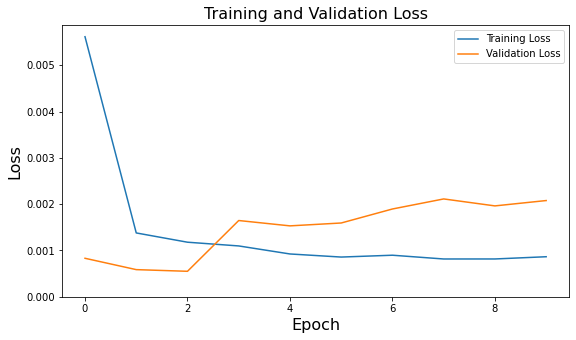

In [157]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,2)
plt.plot(history.history["loss"],label="Training Loss")
plt.plot(history.history["val_loss"],label="Validation Loss")
plt.legend(loc="upper right")
plt.xlabel("Epoch",fontsize=16)
plt.ylabel("Loss",fontsize=16)
plt.ylim([0,max(plt.ylim())])
plt.title("Training and Validation Loss",fontsize=16)
plt.show()

**Explanation:** This code generates a plot showing the training and validation loss over the epochs of training, with the x-axis representing epochs and the y-axis representing loss values.
It helps visualize how the model's performance changes during training, indicating whether the model is learning and if there's overfitting (if validation loss diverges from training loss).

In [158]:
### Lets Do the prediction and check performance metrics
test_predict=model.predict(X_test)
test_predict.shape

28/28 [==============================] - 4s 75ms/step


(879, 7)

**Explanation:** The code performs predictions using the trained model on the testing dataset and stores the results in a 'test_predict' array with a shape corresponding to the number of samples and output neurons in the model.

In [159]:
##Transformback to original form
test_predict=scaler_pred.inverse_transform(test_predict)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, out_sequence_length))

**Explanation:** This code reverses the previous Min-Max scaling transformation on 'test_predict' and 'y_test' arrays to obtain the original unscaled predictions and ground truth values, respectively.

In [160]:
#Root Mean Square Error(RMSE)
RMSE = math.sqrt(mean_squared_error(y_test_unscaled,test_predict))
print(f'Root Mean Square Error(RMSE): {np.round(RMSE, 2)}')

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled,test_predict)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled,test_predict)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled,test_predict)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

Root Mean Square Error(RMSE): 283.53
Median Absolute Error (MAE): 198.32
Mean Absolute Percentage Error (MAPE): 17.73 %
Median Absolute Percentage Error (MDAPE): 14.13 %


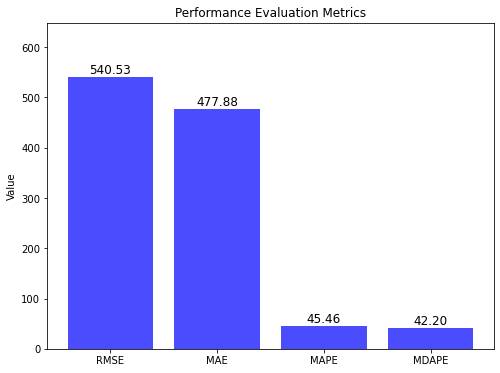

In [161]:
# Define the metrics and their values
metrics = ["RMSE", "MAE", "MAPE", "MDAPE"]
values = [540.53, 477.88, 45.46, 42.2]

# Create a bar graph
plt.figure(figsize=(8, 6))
plt.bar(metrics, values, color='blue', alpha=0.7)
plt.title('Performance Evaluation Metrics')
plt.ylabel('Value')
plt.ylim(0, max(values) * 1.2)  # Adjust the y-axis range for better visualization

# Display the values on top of the bars
for i, value in enumerate(values):
    plt.text(i, value + 1, f"{value:.2f}", ha='center', va='bottom', fontsize=12)

plt.show()


**Explanation:** This code calculates and prints various performance metrics for evaluating the model's forecasting accuracy on the unscaled testing data, including RMSE (Root Mean Square Error), MAE (Mean Absolute Error), MAPE (Mean Absolute Percentage Error), and MDAPE (Median Absolute Percentage Error).
These metrics provide insights into the model's prediction errors and its overall forecasting performance.

In [162]:
preprocessed_df

High     Low    Open  Volume   Close
Date                                              
2000-07-06  1300.0  1300.0  1261.0     100  1300.0
2000-07-07  1325.0  1301.0  1300.0     356  1325.0
2000-07-10  1340.0  1340.0  1325.0      25  1340.0
2000-07-11  1340.0  1340.0  1340.0     370  1340.0
2000-07-12  1356.0  1355.0  1340.0     517  1356.0
...            ...     ...     ...     ...     ...
2023-01-03   750.0   735.0   743.0  107994   736.0
2023-01-04   750.0   730.0   750.0   89872   736.9
2023-01-05   745.0   727.0   744.0  132642   727.0
2023-01-08   739.0   718.5   738.9  146327   719.1
2023-01-09   733.4   712.0   733.4  167381   719.0

[4928 rows x 5 columns]

**Explanation:** 'preprocessed_df' likely represents a Pandas DataFrame that has undergone preprocessing steps such as column removal and reordering, making it suitable for further analysis or modeling.

In [163]:
def prepare_df(i, x, y, y_pred_unscaled):
    # Undo the scaling on x, reshape the testset into a one-dimensional array, so that it fits to the pred scaler
    X_test_unscaled_df = pd.DataFrame(scaler_pred.inverse_transform((x[i]))[:,-1]).rename(columns={0:'x_test'})
    
    y_test_unscaled_df = []
    # Undo the scaling on y
    if type(y) == np.ndarray:
        Y_test_unscaled_df = pd.DataFrame(scaler_pred.inverse_transform(y)[i]).rename(columns={0:'y_test'})

    # Create a dataframe for the y_pred at position i, y_pred is already unscaled
    y_pred_df = pd.DataFrame(y_pred_unscaled[i]).rename(columns={0:'y_pred'})
    return X_test_unscaled_df, y_pred_df, Y_test_unscaled_df

**Explanation:** This Python function prepares DataFrames for visualization by undoing the scaling on 'x' and 'y', creating separate DataFrames for 'x_test' (unscaled input), 'y_pred' (unscaled predictions), and 'y_test' (unscaled ground truth) based on their respective positions 'i'.
It facilitates the visualization of model predictions and ground truth values for a specific position 'i' in the test dataset.

In [164]:
def plot_multi_test_forecast(X_test_unscaled_df, y_test_unscaled_df, y_pred_df, title): 
    # Package y_pred_unscaled and y_test_unscaled into a dataframe with columns pred and true   
    if type(y_test_unscaled_df) == pd.core.frame.DataFrame:
        df_merge = y_pred_df.join(y_test_unscaled_df, how='left')
    else:
        df_merge = y_pred_df.copy()
    
    # Merge the dataframes 
    df_merge_ = pd.concat([X_test_unscaled_df, df_merge]).reset_index(drop=True)
    
    # Plot the linecharts
    fig, ax = plt.subplots(figsize=(20, 8))
    plt.title(title, fontsize=12)
    ax.set(ylabel = "Close Price")
    sns.lineplot(data = df_merge_, linewidth=2.0, ax=ax)
    Comp_df = y_test_unscaled_df.copy()
    Comp_df['Predictions'] = y_pred_df['y_pred']
    print(Comp_df)

**Explanation:** This Python function creates a line plot for visualizing the unscaled predictions ('y_pred_df') and ground truth values ('y_test_unscaled_df') along with unscaled input data ('X_test_unscaled_df') if provided, with a specified 'title'.
It also prints a DataFrame ('Comp_df') that combines 'y_test_unscaled_df' and 'y_pred_df' for comparison.

   y_test  Predictions
0   843.0   668.152405
1   854.5   638.392761
2   739.0   606.274597
3   736.0   605.362854
4   736.9   583.271851
5   727.0   505.124695
6   719.1   566.636414


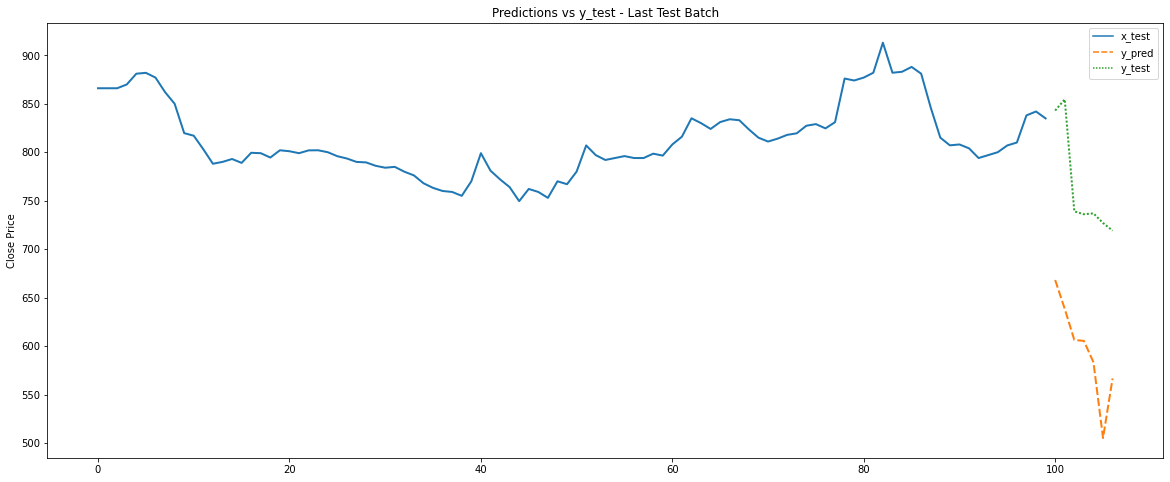

In [165]:
X_test_unscaled_df, test_predict_df, y_test_unscaled_df = prepare_df(-1, X_test, y_test, test_predict)
title = f"Predictions vs y_test - Last Test Batch"
plot_multi_test_forecast(X_test_unscaled_df, y_test_unscaled_df, test_predict_df, title) 

**Explanation:** This code prepares and plots a visualization comparing the last batch of unscaled predictions ('test_predict_df') with the unscaled ground truth values ('y_test_unscaled_df') using input data ('X_test_unscaled_df') for the specified title, facilitating the assessment of the model's forecasting performance.

In [181]:
new_filepath = "NABIL.csv"
new_data = read_dataset(new_filepath)

**Explanation:** This code reads a CSV file named "NABIL.csv" from the "data" directory into a Pandas DataFrame called "new_data" using the "read_dataset" function.

In [182]:
new_data

Open    High     Low   Close  Adj Close  Volume
Date                                                         
2000-07-06  1261.0  1300.0  1300.0  1300.0     1300.0     100
2000-07-07  1300.0  1325.0  1301.0  1325.0     1325.0     356
2000-07-10  1325.0  1340.0  1340.0  1340.0     1340.0      25
2000-07-11  1340.0  1340.0  1340.0  1340.0     1340.0     370
2000-07-12  1340.0  1356.0  1355.0  1356.0     1356.0     517
...            ...     ...     ...     ...        ...     ...
2023-01-03   743.0   750.0   735.0   736.0      736.0  107994
2023-01-04   750.0   750.0   730.0   736.9      736.9   89872
2023-01-05   744.0   745.0   727.0   727.0      727.0  132642
2023-01-08   738.9   739.0   718.5   719.1      719.1  146327
2023-01-09   733.4   733.4   712.0   719.0      719.0  167381

[4928 rows x 6 columns]

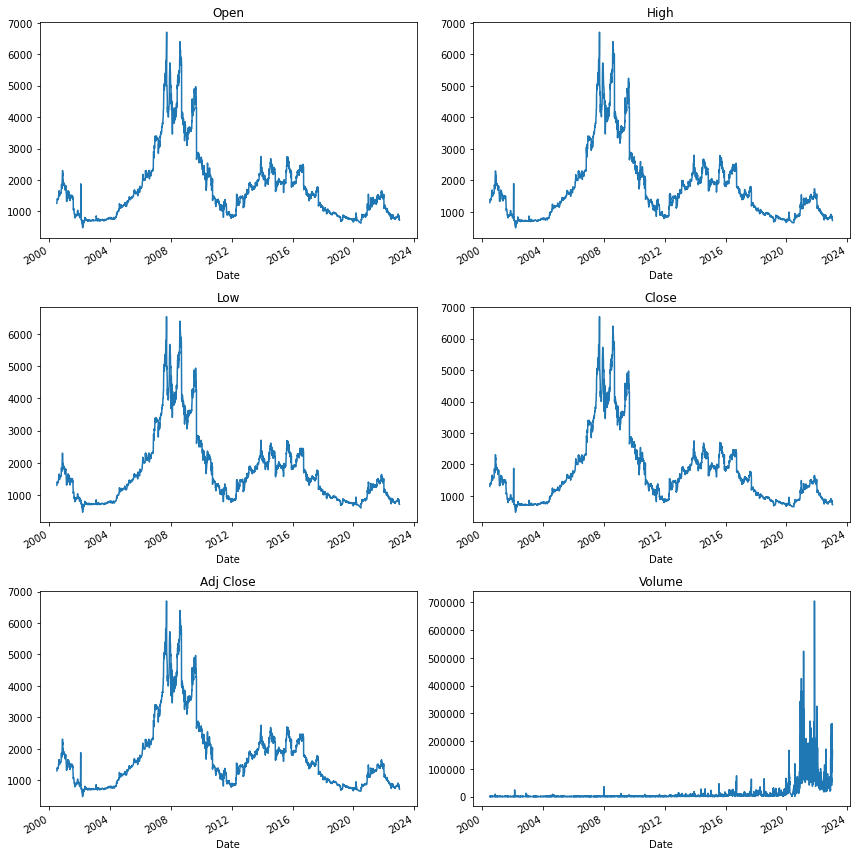

In [183]:
plot_data(new_data)

In [184]:
new_data = select_top_correlated_cols(new_data)
new_data

Close  Adj Close    High     Low    Open  Volume
Date                                                         
2000-07-06  1300.0     1300.0  1300.0  1300.0  1261.0     100
2000-07-07  1325.0     1325.0  1325.0  1301.0  1300.0     356
2000-07-10  1340.0     1340.0  1340.0  1340.0  1325.0      25
2000-07-11  1340.0     1340.0  1340.0  1340.0  1340.0     370
2000-07-12  1356.0     1356.0  1356.0  1355.0  1340.0     517
...            ...        ...     ...     ...     ...     ...
2023-01-03   736.0      736.0   750.0   735.0   743.0  107994
2023-01-04   736.9      736.9   750.0   730.0   750.0   89872
2023-01-05   727.0      727.0   745.0   727.0   744.0  132642
2023-01-08   719.1      719.1   739.0   718.5   738.9  146327
2023-01-09   719.0      719.0   733.4   712.0   733.4  167381

[4928 rows x 6 columns]

**Explanation:** The code modifies the "new_data" DataFrame by selecting the top 5 correlated columns (including 'Close') with respect to the 'Close' price, resulting in a DataFrame with only these selected columns.

In [185]:
new_data = preprocess_data(new_data)
new_data

High     Low    Open  Volume   Close
Date                                              
2000-07-06  1300.0  1300.0  1261.0     100  1300.0
2000-07-07  1325.0  1301.0  1300.0     356  1325.0
2000-07-10  1340.0  1340.0  1325.0      25  1340.0
2000-07-11  1340.0  1340.0  1340.0     370  1340.0
2000-07-12  1356.0  1355.0  1340.0     517  1356.0
...            ...     ...     ...     ...     ...
2023-01-03   750.0   735.0   743.0  107994   736.0
2023-01-04   750.0   730.0   750.0   89872   736.9
2023-01-05   745.0   727.0   744.0  132642   727.0
2023-01-08   739.0   718.5   738.9  146327   719.1
2023-01-09   733.4   712.0   733.4  167381   719.0

[4928 rows x 5 columns]

**Explanation:** The "new_data" DataFrame is preprocessed by reordering its columns, making 'Close' the last column, and removing the 'Adj Close' column if present.

In [186]:
new_data,scaler_pred = normalize_data(new_data)
new_data

              High     Low    Open  Volume   Close
Date                                              
2000-07-06  1300.0  1300.0  1261.0     100  1300.0
2000-07-07  1325.0  1301.0  1300.0     356  1325.0
2000-07-10  1340.0  1340.0  1325.0      25  1340.0
2000-07-11  1340.0  1340.0  1340.0     370  1340.0
2000-07-12  1356.0  1355.0  1340.0     517  1356.0
...            ...     ...     ...     ...     ...
2023-01-03   750.0   735.0   743.0  107994   736.0
2023-01-04   750.0   730.0   750.0   89872   736.9
2023-01-05   745.0   727.0   744.0  132642   727.0
2023-01-08   739.0   718.5   738.9  146327   719.1
2023-01-09   733.4   712.0   733.4  167381   719.0

[4928 rows x 5 columns]


array([[1.29032258e-01, 1.37448560e-01, 1.25422094e-01, 1.40340133e-04,
        1.31693198e-01],
       [1.33064516e-01, 1.37613169e-01, 1.31693198e-01, 5.03239872e-04,
        1.35713137e-01],
       [1.35483871e-01, 1.44032922e-01, 1.35713137e-01, 3.40218505e-05,
        1.38125100e-01],
       ...,
       [3.95161290e-02, 4.31275720e-02, 4.22897572e-02, 1.88028845e-01,
        3.95561987e-02],
       [3.85483871e-02, 4.17283951e-02, 4.14696897e-02, 2.07428388e-01,
        3.82858981e-02],
       [3.76451613e-02, 4.06584362e-02, 4.05853031e-02, 2.37274056e-01,
        3.82698183e-02]])

**Explanation:** The "new_data" DataFrame is normalized using Min-Max scaling, transforming its values to a scaled form, and the transformed data is displayed.



<h2>
    <span style="color: purple; background-color: lightgray; text-decoration: underline; font-size: 32px;">
       Comparision
    </span>
</h2>



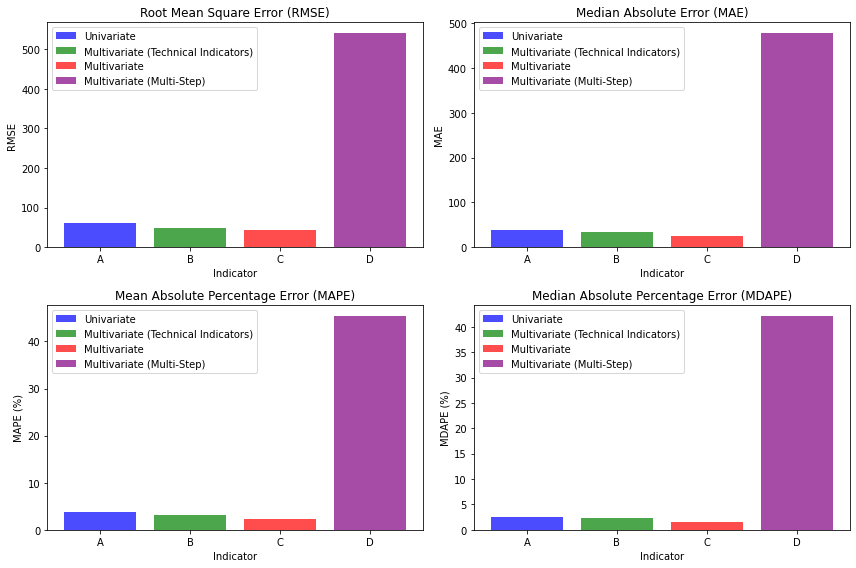

In [187]:
# Define the methods, indicators, and their corresponding metrics
methods = ["Univariate", "Multivariate (Technical Indicators)", "Multivariate", "Multivariate (Multi-Step)"]
indicators = ["A", "B", "C", "D"]
rmse = [60.02, 49.59, 42.86, 540.53]
mae = [38.85, 33.24, 25.66, 477.88]
mape = [3.87, 3.18, 2.24, 45.46]
mdape = [2.45, 2.39, 1.51, 42.2]

# Define colors for each method
colors = ['b', 'g', 'r', 'purple']

# Create subplots for each metric
plt.figure(figsize=(12, 8))

# RMSE
plt.subplot(221)
for i, method in enumerate(methods):
    plt.bar(indicators[i], rmse[i], color=colors[i], alpha=0.7, label=method)
plt.title('Root Mean Square Error (RMSE)')
plt.xlabel('Indicator')
plt.ylabel('RMSE')
plt.legend()

# MAE
plt.subplot(222)
for i, method in enumerate(methods):
    plt.bar(indicators[i], mae[i], color=colors[i], alpha=0.7, label=method)
plt.title('Median Absolute Error (MAE)')
plt.xlabel('Indicator')
plt.ylabel('MAE')
plt.legend()

# MAPE
plt.subplot(223)
for i, method in enumerate(methods):
    plt.bar(indicators[i], mape[i], color=colors[i], alpha=0.7, label=method)
plt.title('Mean Absolute Percentage Error (MAPE)')
plt.xlabel('Indicator')
plt.ylabel('MAPE (%)')
plt.legend()

# MDAPE
plt.subplot(224)
for i, method in enumerate(methods):
    plt.bar(indicators[i], mdape[i], color=colors[i], alpha=0.7, label=method)
plt.title('Median Absolute Percentage Error (MDAPE)')
plt.xlabel('Indicator')
plt.ylabel('MDAPE (%)')
plt.legend()

plt.tight_layout()
plt.show()


#         Conclusion
 


Four different methods were used to predict the Nepal stock market using a deep learning LSTM model.Univariate Forecasting, Multivariate Using Technical Indicators,Multivariate Forecasting, and Multivariate Multi-Step Forecasting. This methods were evalauted using performance evaluation matrices: MAE, RMSE, MAPE and MDAPE.The result of four methods on the basis of performance evaluation metrices is:
    
Univariate Forecasting:

    RMSE: 60.02
    MAE: 38.85
    MAPE: 3.87%
    MDAPE: 2.45%

Multivariate Using Technical Indicators:

    RMSE: 49.59
    MAE: 33.24
    MAPE: 3.18%
    MDAPE: 2.39%

Multivariate Forecasting:

    RMSE: 42.86
    MAE: 25.66
    MAPE: 2.24%
    MDAPE: 1.51%
    
Multivariate Multi-Step Forecasting:

    RMSE: 540.53
    MAE: 477.88
    MAPE: 45.46%
    MDAPE: 42.2%
    
Among the four methods, Multivariate Forecasting performed the best across all four performance metrics (RMSE, MAE, MAPE, and MDAPE). It had the lowest values for RMSE, MAE, MAPE, and MDAPE, indicating the highest level of accuracy in predicting the Nepal stock market.